# Main idea behind the project!

The idea of this project is to train two classifiers that when used in conjunction can take a 
recepie and predict its cuisine. 

* Classifier N1 is a Bi-LSTM NER model that predicts the ingredients
* Classifier N2 is a non-linear SVM that predicts cuisine based on those ingredients

### Contents:
1. Research Questions
2. Data exploration
3. Data analysis 
4. Prediction
    * Classification
    * Structured Prediction


## 1. Research Question(s)

In this notebook I will be investigating 2 distinct questions:

* Cuisine Similarity - different cuisines around the world range from extremely similar to very different, in this file we explore the clustering of different such cuisines
* Cuisine Trend Detection - consumer preferences change with time and different trends emerge. In this file I use an SVM classifier in conjunction with a Bi-LSTM NER model to analyse the current trends in cuisine taste/ home cooking. 

In [2]:
import json
import numpy as np
import pandas as pd
import time
import re
import pickle
import random
import itertools
import sys
import string
import multiprocessing
from tqdm import tqdm

np.set_printoptions(precision=2)

import collections
from collections import Counter, defaultdict 

from ast import literal_eval
from gensim.models import Word2Vec
from gensim.models import LdaMulticore, TfidfModel, CoherenceModel
from gensim.models.callbacks import CallbackAny2Vec
from gensim.models.word2vec import FAST_VERSION
from gensim.corpora import Dictionary
from gensim.models.phrases import Phrases


import nltk
from nltk.stem import WordNetLemmatizer
import spacy

from bayes_opt import BayesianOptimization
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.datasets import make_blobs
from sklearn.decomposition import TruncatedSVD, PCA, NMF
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, classification_report, accuracy_score, silhouette_samples, silhouette_score
from sklearn.model_selection import cross_val_score, StratifiedKFold, StratifiedShuffleSplit, train_test_split, GridSearchCV
from sklearn.svm import LinearSVC, SVC

from keras import backend as K
from keras.models import Model
from keras.layers import Concatenate
from keras.layers import Input, Embedding
from keras.layers import Bidirectional, LSTM
from keras.layers import Dropout, Dense, Activation
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

#Visuzalization
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from pylab import *
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
sns.set_style("darkgrid")
sns.set_context("notebook")

In [2]:
def plot_vectors(vectors, title='VIZ', labels=None, dimensions=3, color_dict = None):
    """
    plot the vectors in 2 or 3 dimensions. 
    If labels are supplied, use them to color the data accordingly
    """
    # set up graph
    fig = plt.figure(figsize=(10,10))

    # create data frame
    df = pd.DataFrame(data={'x':vectors[:,0], 'y': vectors[:,1]})
    # add labels, if supplied
    if labels is not None:
        df['label'] = labels
    else:
        df['label'] = [''] * len(df)
        
    # assign colors to labels
    cm = plt.get_cmap('spring') # choose the color palette
    n_labels = len(df.label.unique())
        
    if color_dict is not None: 
        label_colors = list(color_dict.values())
    else:
        label_colors = [cm(1. * i/n_labels) for i in range(n_labels)]
        
    cMap = colors.ListedColormap(label_colors)
        
    # plot in 3 dimensions
    if dimensions == 3:
        # add z-axis information
        df['z'] = vectors[:,2]
        # define plot
        ax = fig.add_subplot(111, projection='3d')
        frame1 = plt.gca() 
        # remove axis ticks
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])
        frame1.axes.zaxis.set_ticklabels([])

        # plot each label as scatter plot in its own color
        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            color_values = [label_colors[l]] * len(df2)
            ax.scatter(df2['x'], df2['y'], df2['z'], 
                       c=color_values, 
                       cmap=cMap, 
                       edgecolor='black', 
                       label=label, 
                       alpha=.6, 
                       s=60)
      
    # plot in 2 dimensions
    elif dimensions == 2:
        ax = fig.add_subplot(111)
        frame1 = plt.gca() 
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])

        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            color_values = [label_colors[l]] * len(df2)
            ax.scatter(df2['x'], df2['y'], 
                       c=color_values, 
                       cmap=cMap, 
                       edgecolor='black', 
                       label=label, 
                       alpha=.6, 
                       s=60)

    else:
        raise NotImplementedError()

    plt.title(title)
    plt.legend()
    plt.show()

## 2. Data, Preprocessing, and Annotation (3 pts)

In order to explore those research questions I am using 3 datasets:
* All recipes on allrecepies.com scraped using an API. This data contains the recipies as well as rating which we will use to identify which are the currently "trendy" recipies
* A dataset that has recipe ingredients and the cuisine of the recipe - used in the Simple Prediction
* A new york times dataset with recipes and a list of ingredients used to create the annotated data for Structured Prediction.


There are a few preprocessing steps that are shared between datasets: 
* First I normalize vulgar  fractions in scrapped data so that they can be tokenized properly 
* Next I tokenize both the scraped recipes and the NYT stuctured pred data removing punctuation

Additional preprocessing steps:
* I lematized the words so that ```salts``` and ```salt``` are both counted as the same ingredient
* I removed punctuation, measurement units (such as oz.) and some common adjectived (crushed, sliced etc.)

### Let's move to the actual meat of the project!

#### Initial data exploration of the recepies data

In [3]:
df_allR = pd.read_csv('data/recepies.csv')
df_allR.head()

Unnamed: 0                                                url  \
0           0  https://www.allrecipes.com/recipe/241038/micro...   
1           0  https://www.allrecipes.com/recipe/241038/micro...   
2           0  https://www.allrecipes.com/recipe/241038/micro...   
3           0  https://www.allrecipes.com/recipe/241038/micro...   
4           0  https://www.allrecipes.com/recipe/241038/micro...   

                           name    rating  \
0  Microwave Chocolate Mug Cake  4.476778   
1  Microwave Chocolate Mug Cake  4.476778   
2  Microwave Chocolate Mug Cake  4.476778   
3  Microwave Chocolate Mug Cake  4.476778   
4  Microwave Chocolate Mug Cake  4.476778   

                              ingredients  \
0               1⁄4 cup all-purpose flour   
1                       ¼ cup white sugar   
2  2 tablespoons unsweetened cocoa powder   
3                  ⅛ teaspoon baking soda   
4                         ⅛ teaspoon salt   

                                          directions  
0  1. Mix flour, sugar, cocoa powder, baking soda...  
1  1. Mix flour, sugar, cocoa powder, baking soda...  
2  1. Mix flour, sugar, cocoa powder, baking soda...  
3  1. Mix flour, sugar, cocoa powder, baking soda...  
4  1. Mix flour, sugar, cocoa powder, baking soda...

In [4]:
nlp = spacy.load('en_core_web_sm')

def tokenize(text):
    text = str(text)
    return [token.text for token in nlp(text) if token.text not in string.punctuation]

In [5]:
tqdm.pandas()
df_allR['input_tokenized'] = df_allR.ingredients.progress_apply(tokenize)

100%|██████████| 59950/59950 [05:27<00:00, 182.80it/s]


<AxesSubplot:xlabel='rating', ylabel='Count'>

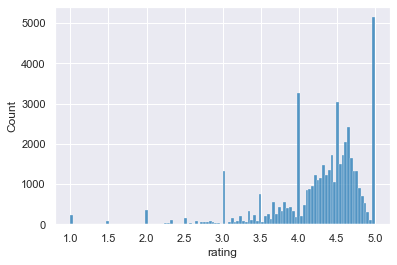

In [46]:
# We can see huge spikes at the whole number values
# This is the case due to recepies with low number of total reviews
sns.histplot(data=df_allR, x = 'rating')

In [47]:
# We can see that by simple tokenization we manage to extract some ingredients out of our raw recepies 
# but we need to getrid of the other stuff such as the measurements
# The Named Entitiy Recognition model will help us with that!
instances = [word for list_ in df_allR.input_tokenized.tolist() for word in list_ if re.sub(r'[0-9]', '(', word) not in string.punctuation]

counts_ins = collections.Counter(instances)

counts_ins.most_common(10)

[('cup', 16255),
 ('½', 9868),
 ('teaspoon', 8701),
 ('cups', 7273),
 ('sugar', 6737),
 ('\u2009', 4860),
 ('white', 4643),
 ('ounce', 4519),
 ('¼', 4177),
 ('butter', 3705)]

#### Cuisine classifiation data exploration

In [6]:
# Before training our NER model tho we will train our classifier that will predict cuisine
# based on ingredient list
with open('data/classification_train.json') as data_file:    
    data = json.load(data_file)
    
with open('data/classification_test.json') as test_file:
    test = json.load(test_file)

In [7]:
df = pd.DataFrame(data)

df.head()

id      cuisine                                        ingredients
0  10259        greek  [romaine lettuce, black olives, grape tomatoes...
1  25693  southern_us  [plain flour, ground pepper, salt, tomatoes, g...
2  20130     filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...
3  22213       indian                [water, vegetable oil, wheat, salt]
4  13162       indian  [black pepper, shallots, cornflour, cayenne pe...

In [50]:
# No null values in train
(df.isnull().sum() / len(df))*100 

id             0.0
cuisine        0.0
ingredients    0.0
dtype: float64

In [51]:
# Data exploration
raw_ingredients = [ing for ing_list in df.ingredients.tolist() for ing in ing_list]
raw_cuisines = df.cuisine.tolist()

# use Counter to get frequencies 
counts_ingr = collections.Counter(raw_ingredients)
counts_cuis = collections.Counter(raw_cuisines)

In [52]:
# Let's get some basic statistics of our dataset
print('Total number of recipies: \t\t{}'.format(len(raw_cuisines)))
print('Total number of cuisines: \t\t{}'.format((len(counts_cuis.values()))))
print('Total number of ingredients:  \t\t{}'.format((len(raw_ingredients))))
print('Unique ingrediets: \t\t\t{}'.format((len(counts_ingr.values()))))

Total number of recipies: 		39774
Total number of cuisines: 		20
Total number of ingredients:  		428275
Unique ingrediets: 			6714


In [53]:
# Lest begin by exploring the cuisines
# Most common cuisines
counts_cuis.most_common(10)

[('italian', 7838),
 ('mexican', 6438),
 ('southern_us', 4320),
 ('indian', 3003),
 ('chinese', 2673),
 ('french', 2646),
 ('cajun_creole', 1546),
 ('thai', 1539),
 ('japanese', 1423),
 ('greek', 1175)]

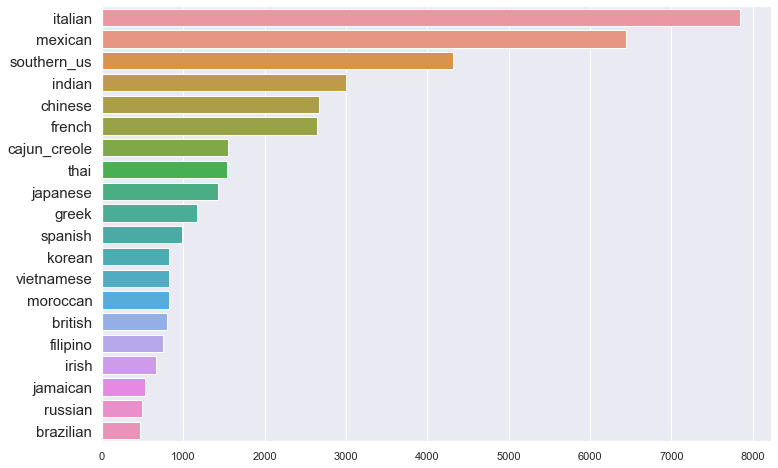

In [54]:
# Lets plot the cuisine distribution
sns.set_style("darkgrid")
sns.set_context("notebook")
sns.set(font_scale = 4)
sns.set(rc={'figure.figsize':(12,8)})

x_c = [c for c, frq in counts_cuis.most_common()]
y_frq = [frq for c, frq in counts_cuis.most_common()]
fbar = sns.barplot(x = y_frq, y = x_c)

fbar.set_yticklabels(fbar.get_ymajorticklabels(), fontsize = 15)
plt.show()

In [55]:
# Now lest explore the ingredients
# First lets see if there is a bias in recepie lenght in different cuisines
num_ingredients = defaultdict(lambda: list())
for index, row in df.iterrows():
    # append the number in the list
    num_ingredients[row['cuisine']].append(len(row['ingredients']))

len(num_ingredients)

20

In [56]:
mean_c_freq = {c: np.mean(frq) for c, frq in num_ingredients.items()}
for c, frq in sorted(mean_c_freq.items(), key=lambda p:p[1], reverse=True):
    if len(c) < 12:
        print('{}    \t\t{:.2f}'.format(c, np.mean(frq)))
        continue
    print('{}    \t{:.2f}'.format(c, np.mean(frq)))

moroccan    		12.91
indian    		12.71
vietnamese    		12.68
cajun_creole    	12.62
thai    		12.55
jamaican    		12.21
chinese    		11.98
korean    		11.28
mexican    		10.88
spanish    		10.42
russian    		10.22
greek    		10.18
filipino    		10.00
italian    		9.91
french    		9.82
japanese    		9.74
british    		9.71
southern_us    		9.63
brazilian    		9.52
irish    		9.30


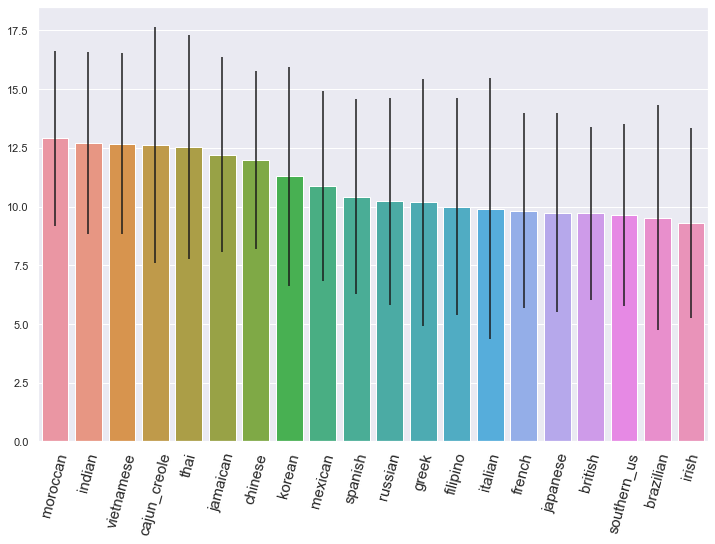

In [57]:
x_cu = [cu for cu, m_frq in sorted(mean_c_freq.items(), key=lambda p:p[1], reverse=True)]
y_frq = [m_frq for cu, m_frq in sorted(mean_c_freq.items(), key=lambda p:p[1], reverse=True)]
err = [np.std(frq) for cu, frq in num_ingredients.items()]
fbar = sns.barplot(x = x_cu, y = y_frq, yerr=err)

fbar.set_xticklabels(fbar.get_xmajorticklabels(), fontsize = 15)

# xlabels
for item in fbar.get_xticklabels():
    item.set_rotation(75)

('salt', 18049)
('onions', 7972)
('olive oil', 7972)
('water', 7457)
('garlic', 7380)
('sugar', 6434)
('garlic cloves', 6237)
('butter', 4848)
('ground black pepper', 4785)
('all-purpose flour', 4632)
('pepper', 4438)
('vegetable oil', 4385)
('eggs', 3388)
('soy sauce', 3296)
('kosher salt', 3113)


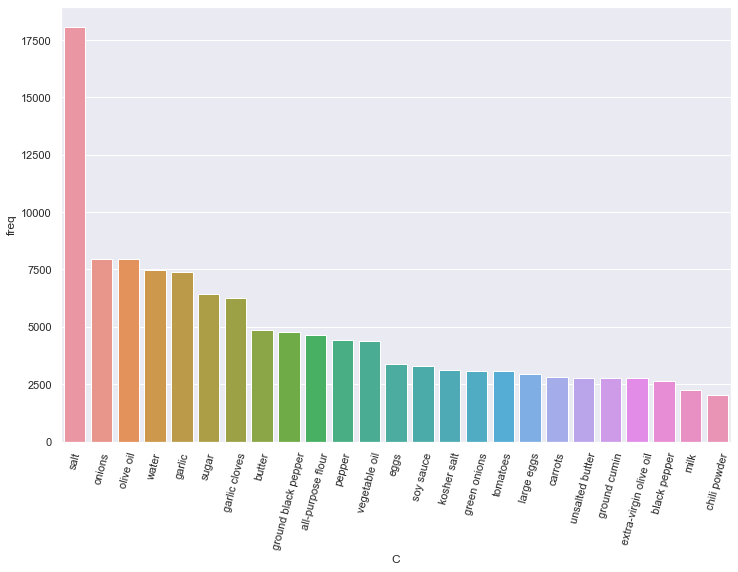

In [58]:
# Finally lets look into the ingredients freq distribution in different recipies
for i in counts_ingr.most_common(15):
    print(i)

fig = sns.barplot(data=pd.DataFrame(counts_ingr.most_common(25),columns=['C','freq']), x='C',y='freq')

# xlabels
for item in fig.get_xticklabels():
    item.set_rotation(75)

# When you account for both garlic and garlic cloves garlic and onions 
# become the top 2 and 3 ingredients proving that Bulgarian cuisine is one of the best!

In [30]:
print('Ingredients freq mean: \t{}'.format(np.mean(list(counts_ingr.values()))))
print('Ingredients freq std: \t{}'.format(np.std(list(counts_ingr.values()))))

Ingredients freq mean: 	63.7883526958594
Ingredients freq std: 	388.3270259662557


In [31]:
# Since the std is too big the plot is not informative so lets look at percentiles
print('Median: \t\t\t{}'.format(np.median(list(counts_ingr.values()))))
print("Percentiles: \t\t\t{:.2f}, {:.2f}, {:.2f}".format(*np.percentile(list(counts_ingr.values()), [25, 50, 75])))

# Finally to see how long our right tail is lets chck the 95th and 99th percentiles
print("95th and 99th percentiles: \t{:.2f}, {:.2f}".format(*np.percentile(list(counts_ingr.values()), [95, 99])))

Median: 			4.0
Percentiles: 			1.00, 4.00, 20.00
95th and 99th percentiles: 	231.05, 1156.44


In [32]:
# Now lets inspect the least common ingredients for typos
counts_ingr.most_common()[-50:]

[('tonic water', 1),
 ('Chartreuse Liqueur', 1),
 ('aloe juice', 1),
 ('salt free chili powder', 1),
 ('tofu sour cream', 1),
 ('spicy salami', 1),
 ('Honeysuckle White® Hot Italian Turkey Sausage Links', 1),
 ('chocolate extract', 1),
 ('chocolate graham crackers', 1),
 ('cumberland sausage', 1),
 ('cocktail pumpernickel bread', 1),
 ('chunky tomatoes', 1),
 ("Colman's Mustard Powder", 1),
 ('manouri', 1),
 ('cherry vanilla ice cream', 1),
 ('bone-in ribeye steak', 1),
 ('frozen lemonade concentrate, thawed and undiluted', 1),
 ('flowering chinese chives', 1),
 ('praline topping', 1),
 ('riblets', 1),
 ('puff paste', 1),
 ('Barilla Plus Pasta', 1),
 ('turkey giblet stock', 1),
 ('light chicken stock', 1),
 ('conchiglie', 1),
 ('2% milk shredded mozzarella cheese', 1),
 ('Makers Mark Whisky', 1),
 ('knorr pasta side   cheesi cheddar', 1),
 ('whole grain baguette', 1),
 ('reduced sodium ham', 1),
 ('whole wheat peasant bread', 1),
 ('ranch-style seasoning', 1),
 ('ketjap', 1),
 ('chocol

In [33]:
# We can see that some preprocessing is required 
symbols = list()
search_pattern= "^(.*?(\(|@|\$|\?)[^$]*)$"


for index, row in df.iterrows():
    for ingredient in row['ingredients']:
        if re.match(search_pattern, ingredient.lower()):
            symbols.append(ingredient)
len(symbols)
counts_symbols = collections.Counter(symbols)
counts_symbols.most_common()

[('(    oz.) tomato sauce', 11),
 ('(   oz.) tomato paste', 9),
 ('flour tortillas (not low fat)', 4),
 ('besan (flour)', 3),
 ('(14.5 oz.) diced tomatoes', 3),
 ('(15 oz.) refried beans', 3),
 ('(10 oz.) frozen chopped spinach', 3),
 ('(10 oz.) frozen chopped spinach, thawed and squeezed dry', 2),
 ('asafetida (powder)', 2),
 ('(14 oz.) sweetened condensed milk', 2),
 ('hing (powder)', 2),
 ('kielbasa (not low fat)', 1)]

In [59]:
nltk.download('wordnet')
nltk.download('omw-1.4')

def preprocess_df(df):
    
    def process_string(recipe):
        prep_r = []
        for ing in recipe:
            ing = [WordNetLemmatizer().lemmatize(word) for word in ing.split()]
            ing = ' '.join(ing)
            ing = re.sub(r'\(.*oz.\)|crushed|crumbles|ground|minced|powder|chopped|sliced','', ing)
            ing = re.sub("[^a-zA-Z]", " ", ing)
            ing = ing.lower().strip()
            prep_r.append(ing)
            
        return prep_r
    
    df = df.drop('id',axis=1)
    df['ingredients'] = df['ingredients'].apply(process_string)
    
    return df

df = preprocess_df(df)
df.head()

[nltk_data] Downloading package wordnet to /home/dimitar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/dimitar/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


cuisine                                        ingredients
0        greek  [romaine lettuce, black olive, grape tomato, g...
1  southern_us  [plain flour, pepper, salt, tomato, black pepp...
2     filipino  [egg, pepper, salt, mayonaise, cooking oil, gr...
3       indian                [water, vegetable oil, wheat, salt]
4       indian  [black pepper, shallot, cornflour, cayenne pep...

In [65]:
def get_cuisine_cumulated_ingredients(df):
    cuisine_df = pd.DataFrame(columns=['ingredients'])

    for cus in df["cuisine"].unique():
        cuisine_df.loc[cus,'ingredients'] = []
        for x in df[df.cuisine == cus]['ingredients']:
            cuisine_df.loc[cus,'ingredients'].extend(x)

    cuisine_df = cuisine_df.reset_index()
    cuisine_df = cuisine_df.rename(columns ={'index':'cuisine'})
    return cuisine_df

cuisine_df = get_cuisine_cumulated_ingredients(df)
cuisine_df.head()

cuisine                                        ingredients
0        greek  [romaine lettuce, black olive, grape tomato, g...
1  southern_us  [plain flour, pepper, salt, tomato, black pepp...
2     filipino  [egg, pepper, salt, mayonaise, cooking oil, gr...
3       indian  [water, vegetable oil, wheat, salt, black pepp...
4     jamaican  [plain flour, sugar, butter, egg, fresh ginger...

## 3. Analysis

In the Anlysis below the follow teqniques were used:

* Word embeddings
* TFIDF analysis
* Topic models
* Dimensionality reduction
* Clustering

First lets explore our raw scrapped recepie data using topic modelling, more specifically 
I am gonna see if there is a difference in topics between ratings

In [376]:
df_TM = df_allR
df_TM.head()

tqdm.pandas()

def clean(text):
    return ' '.join([token.lemma_ for token in nlp(str(text)) if token.pos_ in {'NOUN', 'VERB', 'ADJ', 'ADV', 'X', 'PROPN'} and token.text not in string.punctuation]) # if the word is a content word

df_TM['directions_cleaned'] = df_TM.directions.progress_apply(clean)

100%|████████████████████████████████████████████████████████████████████████████| 59950/59950 [32:09<00:00, 31.07it/s]


In [377]:
# remove empty entries
df_TM = df_TM[df_TM['directions_cleaned'].notnull()]
# make sure everything is a string
df_TM['directions_cleaned'] = df_TM['directions_cleaned'].apply(str)

len(df)

39774

In [379]:
instances = df_TM['directions_cleaned'].apply(str.split).tolist()
print("creating dictionary", flush=True)
# read in instances and create Dictionary object w information about frequencies etc. 
phrases = Phrases(instances, min_count=3, threshold=1)
instances_colloc = phrases[instances]

dictionary = Dictionary(instances_colloc)
# get rid of words that are too rare or too frequent
dictionary.filter_extremes(no_below=50, no_above=0.3)
print(dictionary, flush=True)

creating dictionary
Dictionary(1839 unique tokens: ['canola_oil', 'cocoa', 'cook', 'do', 'microwave']...)


In [380]:
#replace words by their numerical IDs and their frequency
print("translating corpus to IDs", flush=True)
ldacorpus = [dictionary.doc2bow(text) for text in instances]
# learn TFIDF values from corpus
print("tf-idf transformation", flush=True)
tfidfmodel = TfidfModel(ldacorpus) # fit model
# transform raw frequencies into TFIDF
model_corpus = tfidfmodel[ldacorpus] # apply model to the corpus documents

translating corpus to IDs
tf-idf transformation


In [381]:
Counter([phrase for phrases in phrases[instances] for phrase in phrases]).most_common(10)

[('cake', 132168),
 ('pan', 130634),
 ('degree', 127038),
 ('minute', 126830),
 ('bowl', 120138),
 ('oven', 113136),
 ('sugar', 111601),
 ('beat', 102441),
 ('flour', 94641),
 ('cup', 87179)]

In [382]:
coherence_values = []

dev_size = 10000

for num_topics in range(5, 16):
    model = LdaMulticore(corpus=model_corpus[:dev_size], 
                         id2word=dictionary, 
                         num_topics=num_topics, random_state=42)

    coherencemodel_umass = CoherenceModel(model=model, 
                                          texts=instances[:dev_size], 
                                          dictionary=dictionary, 
                                          coherence='u_mass')

    coherencemodel_cv = CoherenceModel(model=model, 
                                       texts=instances[:dev_size], 
                                       dictionary=dictionary, 
                                       coherence='c_v')

    umass_score = coherencemodel_umass.get_coherence()
    cv_score = coherencemodel_cv.get_coherence()
    
    print(num_topics, umass_score, cv_score)
    coherence_values.append((num_topics, umass_score, cv_score))

5 -2.035868208818871 0.24312414762639373
6 -1.942750613891806 0.25765566348813623
7 -2.1206896655589453 0.23107191321357373
8 -1.785227606287929 0.24808376159488524
9 -1.8115473758528284 0.2617667015751918
10 -1.8286326412446936 0.2440198073889312
11 -1.7086928831203865 0.2602297555459368
12 -1.7741777465658028 0.2753268825707152
13 -1.7071002440913705 0.2548412993536352
14 -1.840380732273747 0.2540305593900188
15 -1.8090210773416837 0.25062201373872434


C:\Users\User\anaconda3\envs\nlp\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\Users\User\anaconda3\envs\nlp\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


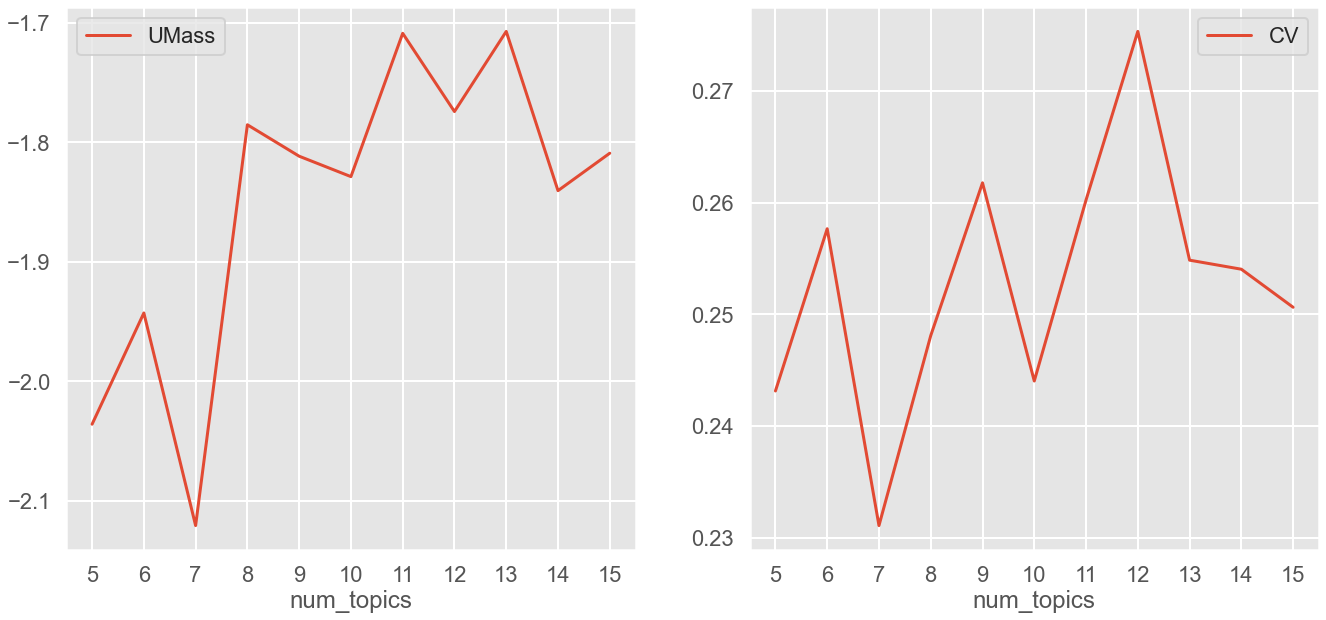

In [383]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn

plt.style.use('ggplot')
seaborn.set_context('poster') 


scores = pd.DataFrame(coherence_values, columns=['num_topics', 'UMass', 'CV'])
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
scores.plot.line(x='num_topics', y='UMass', ax=ax[0], xticks=range(5,16));
scores.plot.line(x='num_topics', y='CV', ax=ax[1], xticks=range(5,16));

Based on the umass and CV scores 7 topics seem to be the best fit (although coherence is low in general for any number of topics)

In [384]:
num_topics = 7

# find chunksize to make about 200 updates
num_passes = 10
chunk_size = len(model_corpus) * num_passes/200
print(chunk_size)

start = time.time()
print("fitting model", flush=True)
model = LdaMulticore(num_topics=num_topics, # number of topics
                     corpus=model_corpus, # what to train on 
                     id2word=dictionary, # mapping from IDs to words
                     workers=min(10, multiprocessing.cpu_count()-1), # choose 10 cores, or whatever computer has
                     passes=num_passes, # make this many passes over data
                     chunksize=chunk_size, # update after this many instances
                     alpha=0.5,
                     random_state=42
                    )
    
print("done in {}".format(time.time()-start), flush=True)

2997.5
fitting model
done in 214.42128539085388


In [385]:
# transform the data into topic distros
topic_corpus = model[model_corpus]

model.print_topics()

# get the topic descriptions
topic_sep = re.compile("0\.[0-9]{3}\*") # getting rid of useless formatting
# extract a list of tuples with topic number and descriptors from the model
model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) 
                for topic_no, model_topic in
                model.print_topics(num_topics=num_topics, num_words=5)]

descriptors = []
for i, m in model_topics:
    print(i+1, ", ".join(m[:5]))
    descriptors.append(", ".join(m[:2]).replace('"', ''))

1 "orange", "loaf", "sift", "light", "then"
2 "dough", "microwave", "cut", "second", "sheet"
3 "dish", "pumpkin", "spray", "baking", "cooking"
4 "crust", "cheesecake", "cheese", "springform", "crumb"
5 "yolk", "peak", "form", "layer", "stiff"
6 "heat", "apple", "boil", "saucepan", "margarine"
7 "cupcake", "muffin", "frost", "tin", "liner"


We can see that we didn't really get out any good topics out this but we got a valauabe insight - alot of our scrapped recipies seem to be about baking and baking sweets more specifically!

In [90]:
# Now lets analyse our data, on this set we will explore word embidings,
# dimensionality reduction and clustering
sentences = [document for document in df.ingredients]

In [91]:
# Due to a issue with gensim the training loss always goes up but can't be trusted, therefore its better
# to take the difference between the loss between steps

# Your model params:
CONTEXT_WINDOW = 10
NEGATIVES = 5
MIN_COUNT = 3
EPOCHS = 15

class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0
        self.losses = list()

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
            self.losses.append(loss)
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
            self.losses.append(loss- self.loss_previous_step)
        self.epoch += 1
        self.loss_previous_step = loss

Loss_logger = callback()
w2v_model = Word2Vec(size = 300,
                      window=CONTEXT_WINDOW,
                      negative=NEGATIVES,
                      min_count=MIN_COUNT,
                      workers = 4
                )
# build vovab
w2v_model.build_vocab(sentences)
  
# train the w2v model
w2v_model.train(sentences, 
                total_examples=w2v_model.corpus_count, 
                epochs=EPOCHS, 
                report_delay=1,
                compute_loss = True, # set compute_loss = True
                callbacks=[Loss_logger]) # add the callback class

Loss after epoch 0: 243745.4375
Loss after epoch 1: 194090.96875
Loss after epoch 2: 183401.15625
Loss after epoch 3: 192848.0625
Loss after epoch 4: 173291.5625
Loss after epoch 5: 168621.5625
Loss after epoch 6: 162406.375
Loss after epoch 7: 159794.375
Loss after epoch 8: 157402.75
Loss after epoch 9: 155626.25
Loss after epoch 10: 154750.625
Loss after epoch 11: 151966.375
Loss after epoch 12: 146478.0
Loss after epoch 13: 145956.75
Loss after epoch 14: 144789.75


(4883544, 6424125)

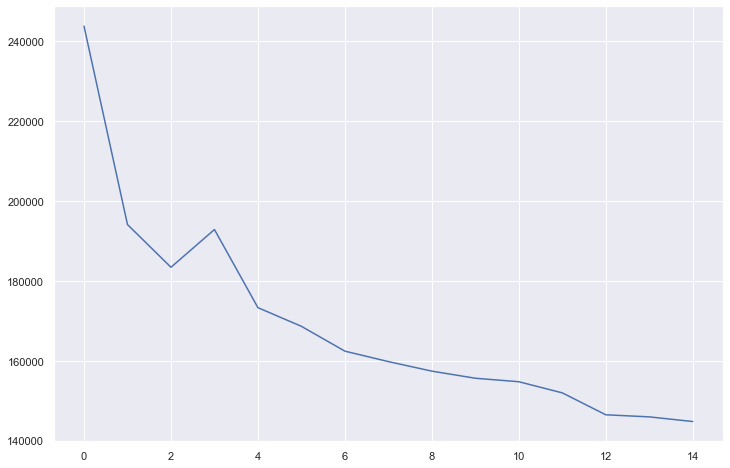

In [92]:
y = Loss_logger.losses
x = [x for x in range(EPOCHS)]

plt.plot(x,y)

In [25]:
# We see that increasing the iter improves the model's loss but 
# a model with lower loss doesn't necessarily give better word-vectors than one with higher!

# Throught experimentation I found that 5 epochs gives the best results!

# initialize model
w2v_model = Word2Vec( 
                 size=300, # vector size
                 window=10, # Set context to be the average recepie lenght
                 iter = 5,
                 negative=5, # negative samples
                 min_count=3, # minimum threshold (must appear in atleast 0.01 percent)
                 workers=4, # Using the number of cores of my machine N.B! the -1 arguement led to mistakes!
)

# build the vocabulary
w2v_model.build_vocab(sentences)

# train the model
w2v_model.train(sentences, 
                total_examples=w2v_model.corpus_count, 
                epochs=w2v_model.epochs)

(1627749, 2141375)

In [26]:
# As we can see the words similar to feta cheese are greek cuisine related
# and thinks one would expect to go with feta cheese
w2v_model.wv.most_similar(u'feta cheese')

[('kalamata', 0.9515801072120667),
 ('pitted kalamata olive', 0.9120593070983887),
 ('olive', 0.9016854763031006),
 ('fresh oregano', 0.9014294147491455),
 ('pita wedge', 0.8932092189788818),
 ('roasted red pepper', 0.8894803524017334),
 ('pita', 0.8829101324081421),
 ('grape tomato', 0.8738828897476196),
 ('crusty roll', 0.8651031851768494),
 ('caper', 0.8633356094360352)]

Now lets santity check our model with some examples

It seems like the model is identifying ingredients that are used in similar way/are ussually used together


In [27]:
# Beans and eggs doesnt sound tasty and the model agrees!
w2v_model.wv.similarity('bean', 'egg')

0.28961304

In [28]:
# Beans and broccoli don't really go together but at least they are both veggies
w2v_model.wv.similarity('bean', 'broccoli')

0.51072884

In [29]:
# Beans and beef is a classic combination, but beef is not exactly a vegetable
w2v_model.wv.similarity('bean', 'beef')

0.6489482

In [30]:
# You can't argue with the beans and corn combination!
w2v_model.wv.similarity('bean', 'corn')

0.8420552

#### Now lets play around with it!

We can check for analogies, for example onion and garlic often appear together, so what appears together with curry?

In [32]:
x = 'curry'
a = 'garlic'
b = 'onion'
predicted = w2v_model.wv.most_similar(positive = [x, b], negative = [a])[0][0]
print(" {} is to  {} as {} is to {} ".format(a, b, x, predicted))

 garlic is to  onion as curry is to turmeric 


In [33]:
# Sometimes the model makes a lot of sense
# if you add water and salt and remove the water sea salt does sound like a good suggestion
x = 'water'
a = 'water'
b = 'salt'
predicted = w2v_model.wv.most_similar(positive = [x, b], negative = [a])[0][0]
print(" {} is to  {} as {} is to {} ".format(a, b, x, predicted))

 water is to  salt as water is to sea salt 


In [34]:
# Sometimes it really doesnt unless you like your salmon with lettuce
x = 'salmon'
a = 'bacon'
b = 'egg'
predicted = w2v_model.wv.most_similar(positive = [x, b], negative = [a])[0][0]
print(" {} is to  {} as {} is to {} ".format(a, b, x, predicted))

 bacon is to  egg as salmon is to baby gem lettuce 


In [35]:
# Now lets apply dimensionality reduction and try to visualize our data

# First I will create a matrix holding word embeddings for all our ingredients
corpus = sorted(w2v_model.wv.vocab.keys())
emb_tuple = tuple([w2v_model[v] for v in corpus])
X = np.vstack(emb_tuple)

X.shape

<ipython-input-35-50a751428055>:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  emb_tuple = tuple([w2v_model[v] for v in corpus])


(4003, 300)

In [36]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

C:\Users\User\anaconda3\envs\nlp\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

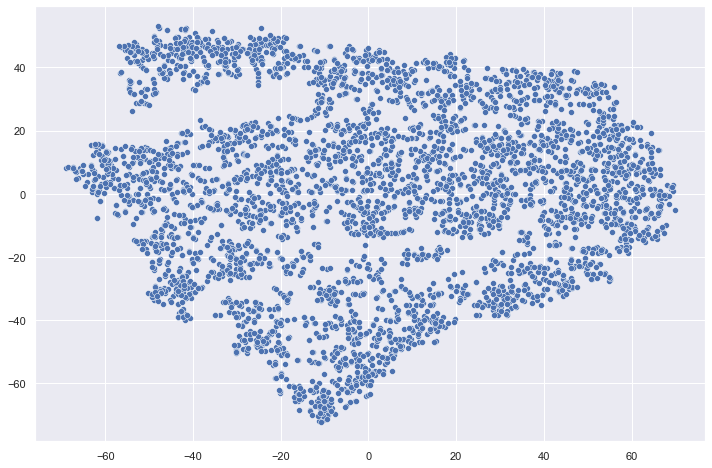

In [37]:
sns.set_style("darkgrid")
sns.set_context("notebook")
sns.set(font_scale = 4)
sns.set(rc={'figure.figsize':(12,8)})

sns.scatterplot(X_tsne[:, 0], X_tsne[:, 1])

In [38]:
# It looks like there might be some clusters, but we need to identify which 
# vector belongs to which cuisine.

# To do that I will label the ingredient to the cuisine in which it appears the most
def return_most_popular(v):
    cuisine = None
    record = 0
    for index, row in cuisine_df.iterrows():
        counter  = collections.Counter(row['ingredients'])
        norm_freq = float(counter[v]) / float(counts_cuis[row['cuisine']])
        if norm_freq > record:
            cuisine = row['cuisine']
            record = norm_freq
    return cuisine

In [39]:
cuisine_vec = np.array([return_most_popular(v) for v in corpus])
data = {'X1': X_tsne[:, 0], 'X2': X_tsne[:, 1], 'cuisine': cuisine_vec}
plot_df = pd.DataFrame(data=data)
plot_df.head()

X1         X2    cuisine
0   2.770830 -10.786584    british
1 -36.650505  48.916855  brazilian
2  44.291836 -26.931952   japanese
3  45.765106 -30.033321   filipino
4  -0.078723 -22.180054   filipino

In [99]:
track_2color = {u'irish':"#000000", # blak
                u'mexican':"#FFFF00", #yellow
                u'chinese':"#1CE6FF", #cyan
                u'filipino': "#FF34FF", #pink 
                u'vietnamese':"#FF4A46", #red
                u'spanish':"#FFC300",  # green forest
                u'japanese':"#006FA6", # blue ocean
                u'moroccan':"#A30059",# purple
                u'french':"#FFDBE5",  #light pink
                u'greek': "#7A4900",  # gold or brown 
                u'indian':"#0000A6", # blue electric 
                u'jamaican':"#63FFAC", # green phospho
                u'british': "#B79762", #brown
                u'brazilian': "#EEC3FF", #  
                u'russian':"#8FB0FF", # light blue 
                u'cajun_creole':"#997D87", #violet
                u'thai':"#5A0007", 
                u'southern_us':"#809693", 
                u'korean':"#FEFFE6", #ligt yellow
                u'italian':"#1B4400"}

<AxesSubplot:xlabel='X1', ylabel='X2'>

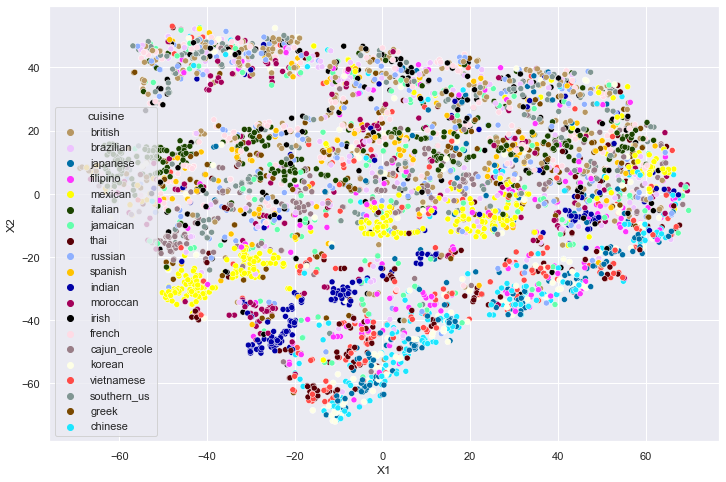

In [41]:
sns.scatterplot(data=plot_df, x='X1', y='X2',hue='cuisine', palette=track_2color)

In [9]:
# It looks like there might be some clusterring of different cuisines
# Furthermore it looks like some cuisines share a lot of ingredients
# Lets explore that by vectorizing the cuisine_df

documents = df.ingredients.apply(lambda x: ' '.join(x)).tolist()

tfidf_vectorizer = TfidfVectorizer(stop_words='english',
                                   analyzer='word', 
                                   min_df=3, # min freq picked with the same value as for Word2Vec
                                   sublinear_tf=True, 
                                   use_idf=True)

cuisine_data_tfidf = tfidf_vectorizer.fit_transform(cuisine_df['ingredients'].apply(str).tolist())

# We will aso vectorize the original documets so that we can cluster them as well in subsequent analysis
train_tfidf  = tfidf_vectorizer.fit_transform(documents)

cuisines = df.cuisine.unique()
categories = df.cuisine

In [94]:
ld_SVD = TruncatedSVD(n_components=2)
low_dim_tsne = TSNE(n_components=2)

In [95]:
low_dim_cus_svd = ld_SVD.fit_transform(cuisine_data_tfidf)
low_dim_cus_tsne = low_dim_tsne.fit_transform(cuisine_data_tfidf)
low_dim_Z = low_dim_tsne.fit_transform(train_tfidf)
low_dim_SVD = ld_SVD.fit_transform(train_tfidf)

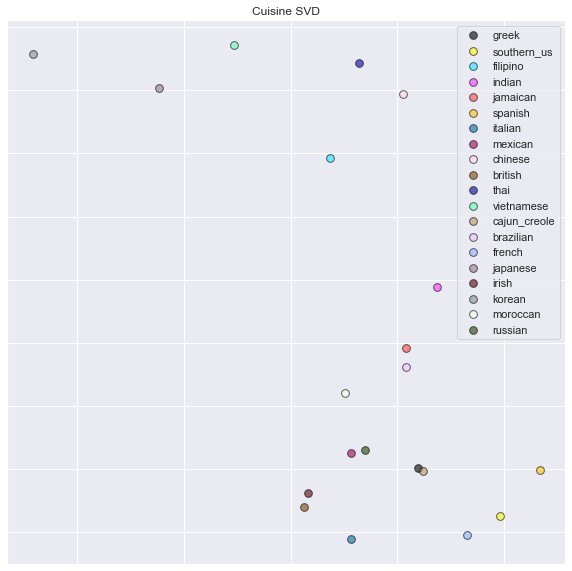

In [100]:
plot_vectors(low_dim_cus_svd, title='Cuisine SVD', labels=cuisines, dimensions=2, color_dict=track_2color)

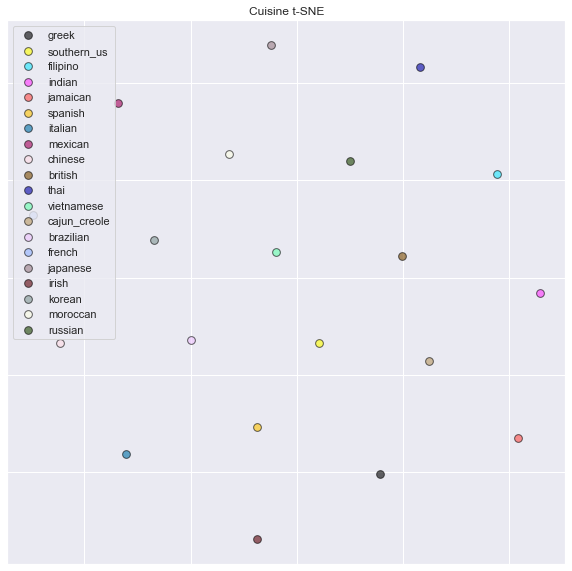

In [101]:
plot_vectors(low_dim_cus_tsne, title='Cuisine t-SNE', labels=cuisines, dimensions=2, color_dict=track_2color)

In [102]:
def silhouette_method_eval(Data, cluster_method = KMeans, range_n_clusters=[2,5,8]):
    silhouette_avg_n_clusters = []

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(Data) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = cluster_method(n_clusters=n_clusters, random_state=42)
        cluster_labels = clusterer.fit_predict(Data)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(Data, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        silhouette_avg_n_clusters.append(silhouette_avg)
        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(Data, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(Data[:, 0], Data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

    plt.show()


    plt.style.use("fivethirtyeight")
    plt.plot(range_n_clusters, silhouette_avg_n_clusters)
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("silhouette score")
    plt.show()

For n_clusters = 2 The average silhouette_score is : 0.7657306102604136
For n_clusters = 3 The average silhouette_score is : 0.6974127713282181
For n_clusters = 4 The average silhouette_score is : 0.6117277361786444
For n_clusters = 5 The average silhouette_score is : 0.510232186412922


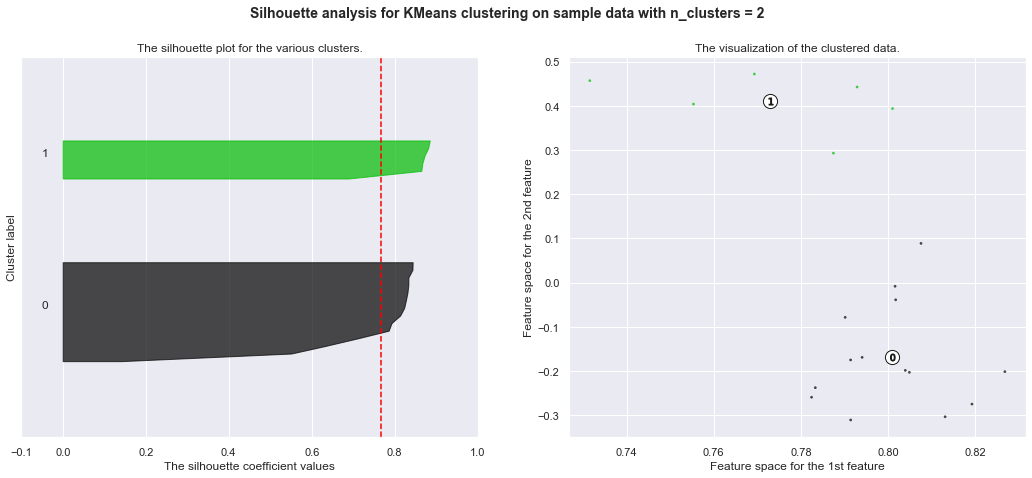

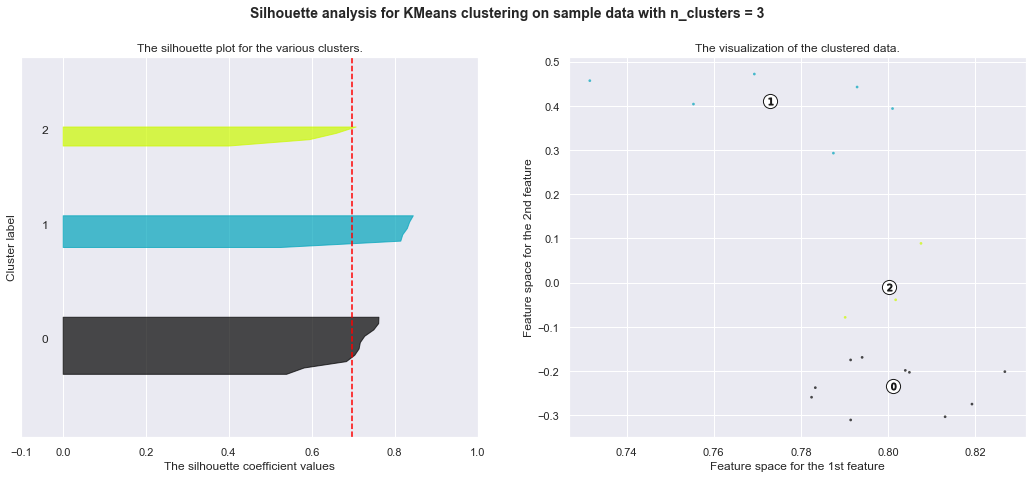

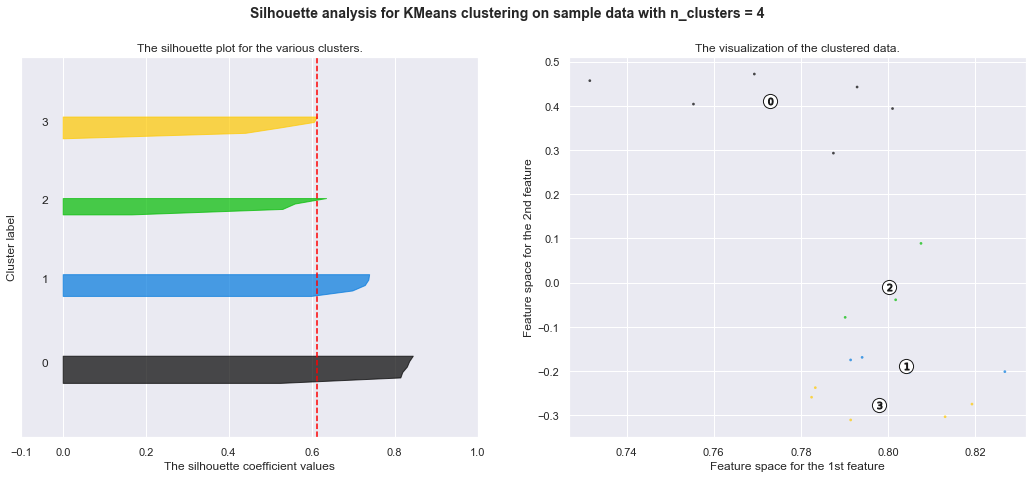

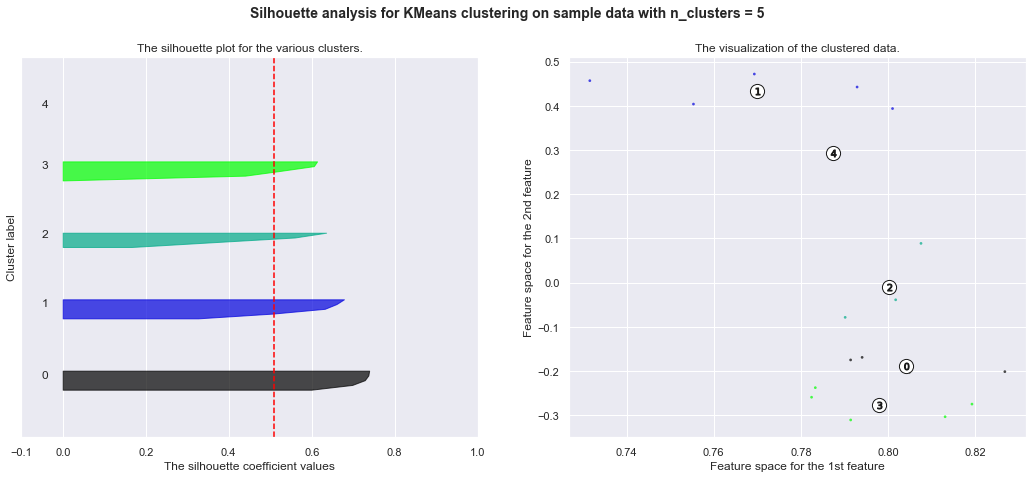

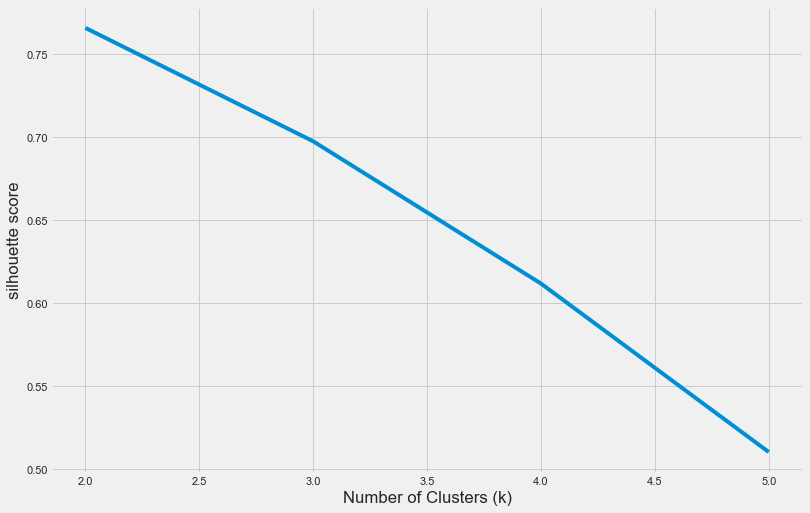

In [103]:
silhouette_method_eval(low_dim_cus_svd, cluster_method = KMeans, range_n_clusters=[2, 3, 4, 5])

For n_clusters = 2 The average silhouette_score is : 0.29524794
For n_clusters = 3 The average silhouette_score is : 0.30049175
For n_clusters = 4 The average silhouette_score is : 0.28209275
For n_clusters = 5 The average silhouette_score is : 0.24683543


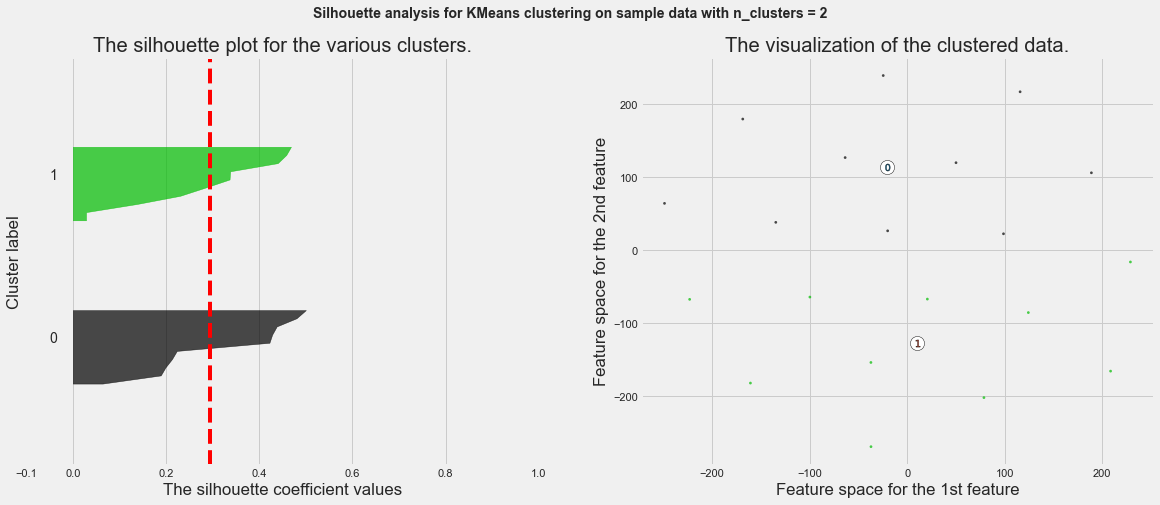

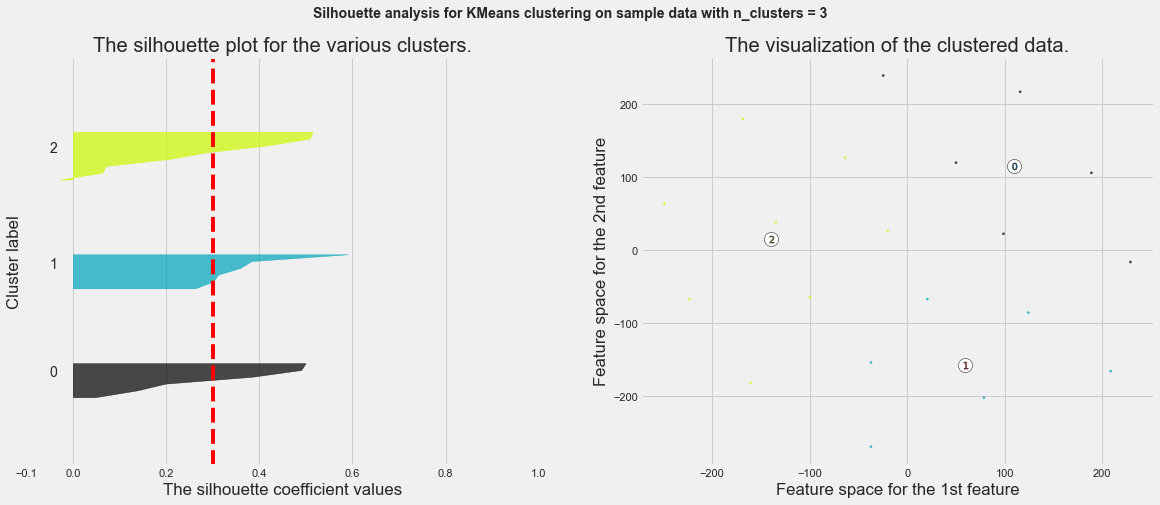

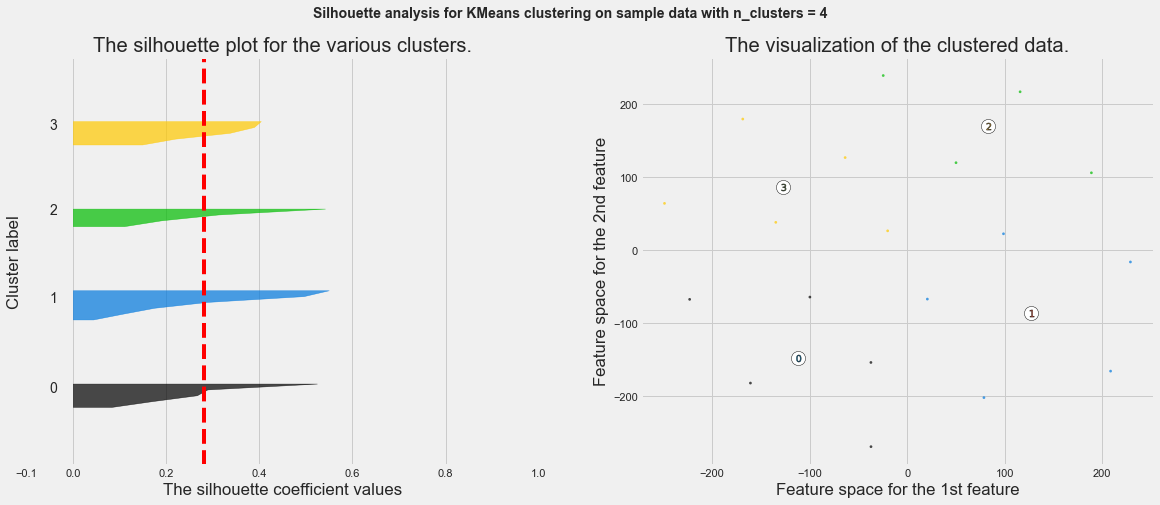

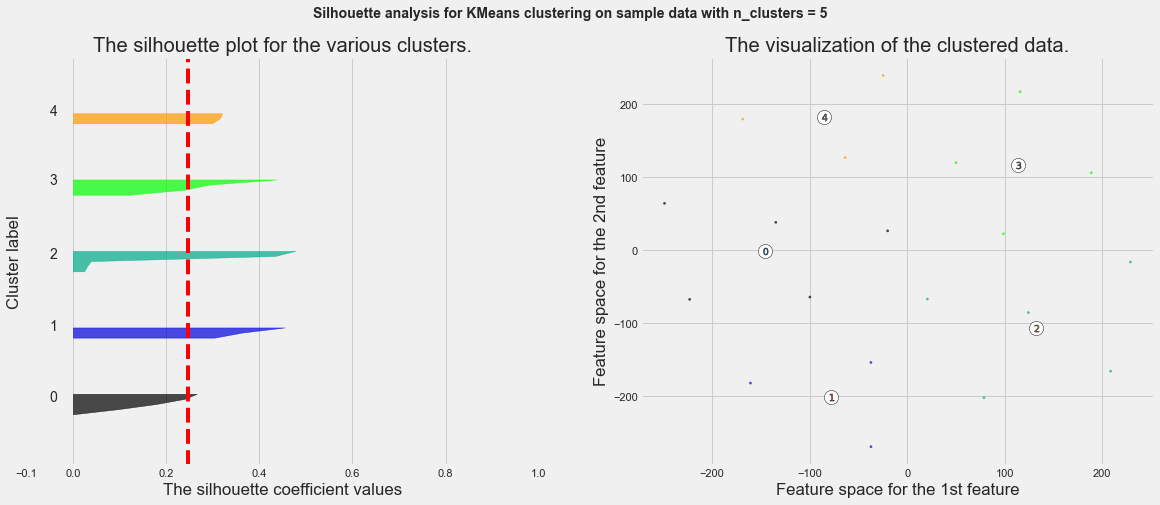

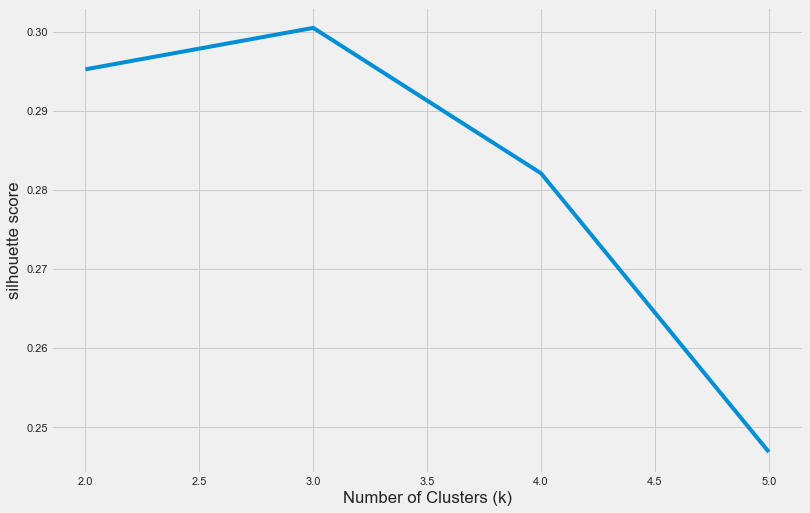

In [104]:
silhouette_method_eval(low_dim_cus_tsne, cluster_method = KMeans, range_n_clusters=[2, 3, 4, 5])

The PCA (truncated SVD) gave us higher silhoette score and therefore we will use it

The goal is to visualize the 3 clusters (shown to be best fit by the silhoette sensitivity analysis) such that we see how much do different quisines overlap!

In [105]:
kmeans = KMeans(init='k-means++', n_clusters=2, n_init=10)
%timeit kmeans.fit(low_dim_cus_svd)

labels = kmeans.predict(low_dim_cus_svd)

9.46 ms ± 71.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [106]:
# JACCARD SIMILARITY (one vs the other cuisines in its cluster)
# We intersect all ingredients of cuisine i with the union of 
# ingredients in all OTHER cuisines in its CLUSTER! (e.g.:
# intersect(filipino_Ingredients, other_asian_Ingredients)
# and divide by the union of all ingredients in the cluster.

i = 0 
j = 0 

effect_on_cluster = [0 for cuisine in cuisines]

for cuisineA in cuisines:  

    A_intersection = 0
    numInClusterBesidesA = 0
    setA = set(cuisine_df[cuisine_df.cuisine == cuisineA]['ingredients'].tolist()[0])
    setB_forA = []
    j = 0
    
    for cuisineB in cuisines:
        if cuisineB != cuisineA: # if it is A itself - we obviously wouldn't want this (will be exactly 1)
            if labels[j] == labels[i]: #determines if then they are both in the same cluster
                setB_forA.extend(set(cuisine_df[cuisine_df.cuisine == cuisineB]['ingredients'].tolist()[0]))
                numInClusterBesidesA += 1
        j += 1
    
    A_intersection = len(set(setA & set(setB_forA))) / float(len(set(setA.union(setB_forA))))
    effect_on_cluster[i] = A_intersection
       
    i += 1

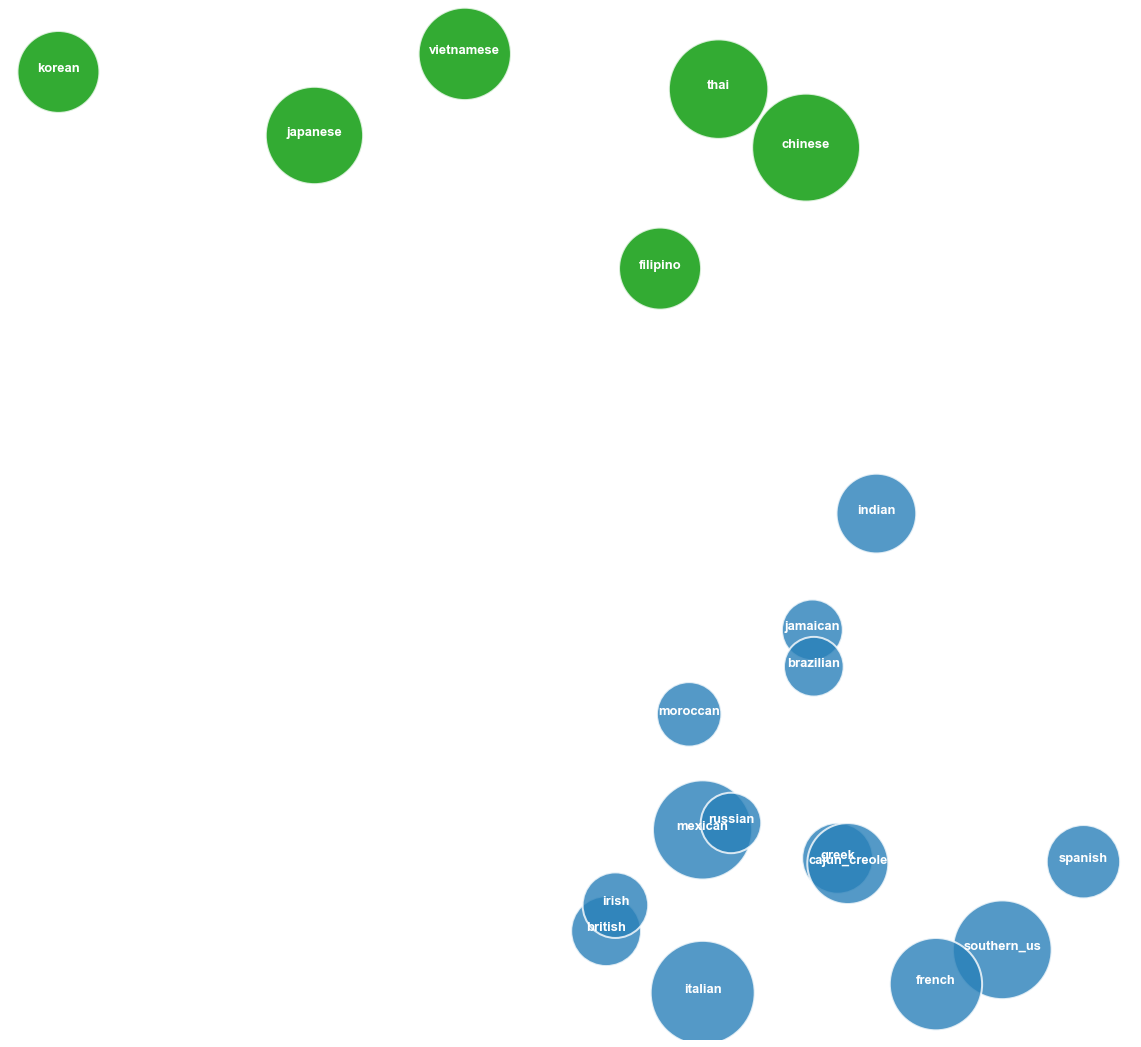

In [110]:
rdata = low_dim_cus_svd
i=0
figureRatios = (18,19)
x = []
y = []
color = []
area = []

#creating a color palette:
colorPalette = ['#009600','#2980b9', '#ff6300'] 
# green,blue, orange, grey, purple

plt.figure(1, figsize=figureRatios)

for data in rdata:
    x.append(data[0] + 100) 
    y.append(data[1] + 100)  
    color.append(colorPalette[labels[i]]) 
    area.append(effect_on_cluster[i]*27000) # magnifying the bubble's sizes (all by the same unit)
    # plotting the name of the cuisine:
    text(data[0]+ 100, data[1] + 100, cuisines[i], size=13,horizontalalignment='center', fontweight = 'bold', color='w')
    i += 1

plt.scatter(x, y, c=color, s=area, linewidths=2, edgecolor='w', alpha=0.80) 

# plt.axis([-0.45,0.65,-0.55,0.55])
# plt.axes().set_aspect(0.8, 'box')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.axis('off') # removing the PC axes

plt.show()

In [111]:
sample = np.random.choice(len(low_dim_Z), replace=False, size=25000)

In [112]:
df.shape

(39774, 2)

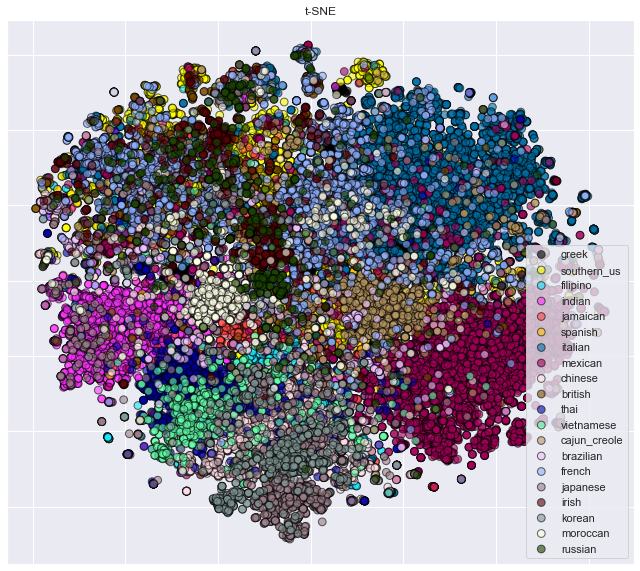

In [114]:
# If we go on to explore the full training data we can see that there is 
# evidence of clustering here as well
plot_vectors(low_dim_Z, title='t-SNE', labels=categories, dimensions=2, color_dict=track_2color)

For n_clusters = 3 The average silhouette_score is : 0.38397515
For n_clusters = 4 The average silhouette_score is : 0.38076258
For n_clusters = 5 The average silhouette_score is : 0.37751195
For n_clusters = 8 The average silhouette_score is : 0.36821124
For n_clusters = 15 The average silhouette_score is : 0.35678667
For n_clusters = 20 The average silhouette_score is : 0.3460106
For n_clusters = 25 The average silhouette_score is : 0.35251936


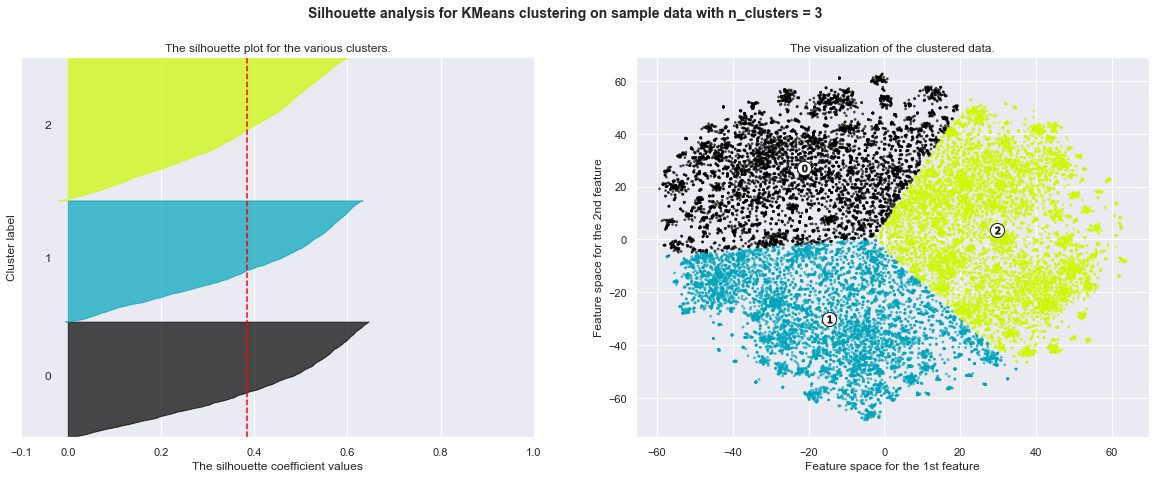

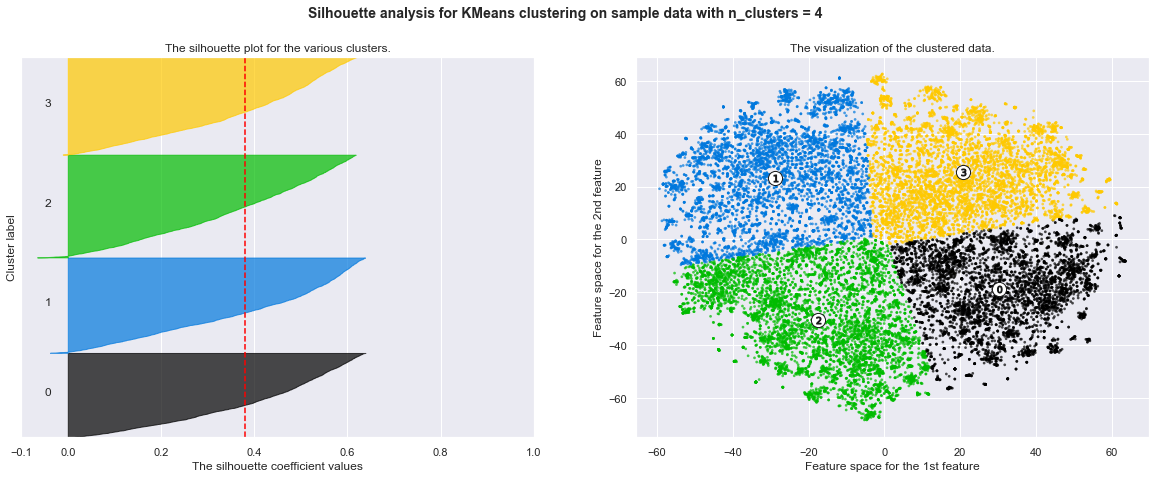

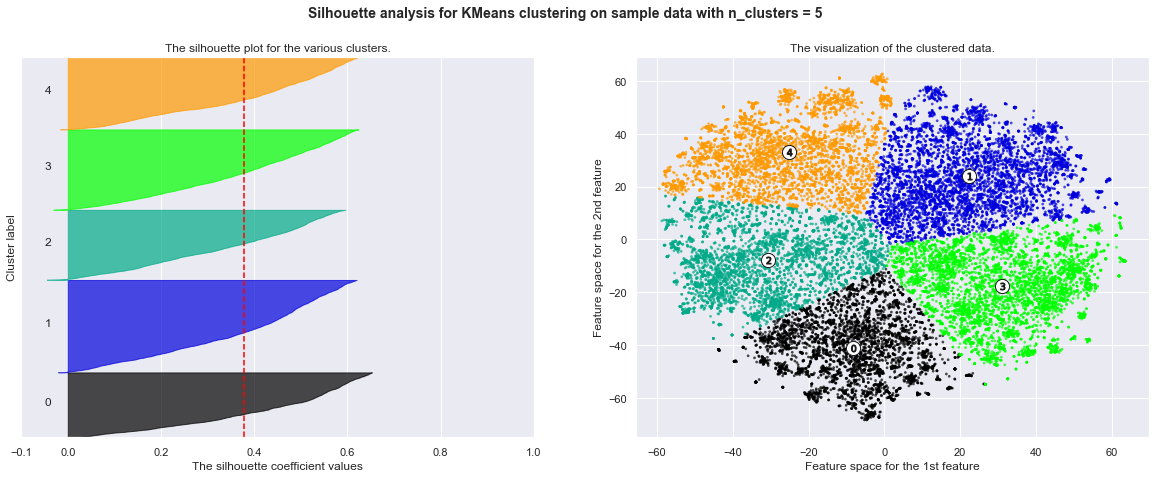

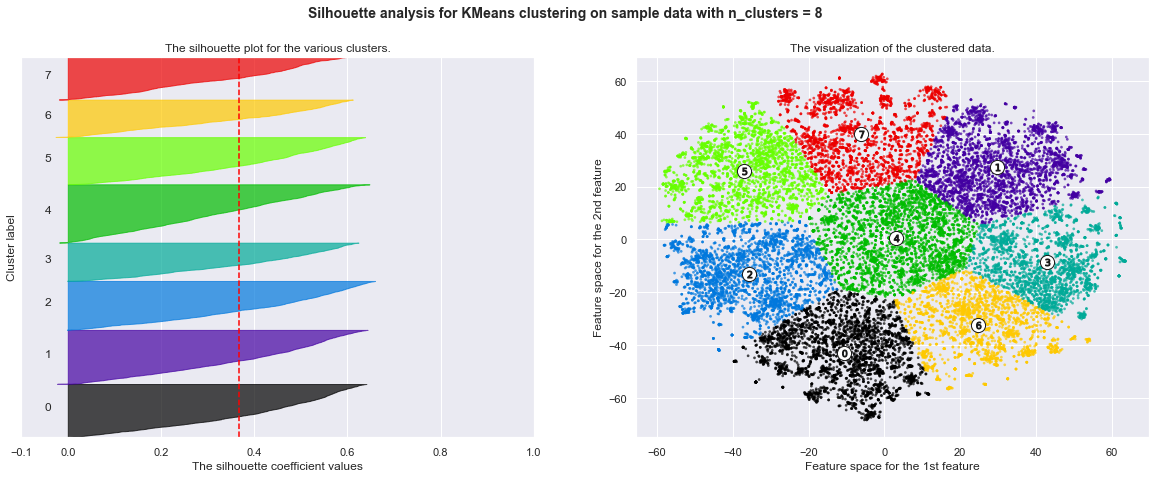

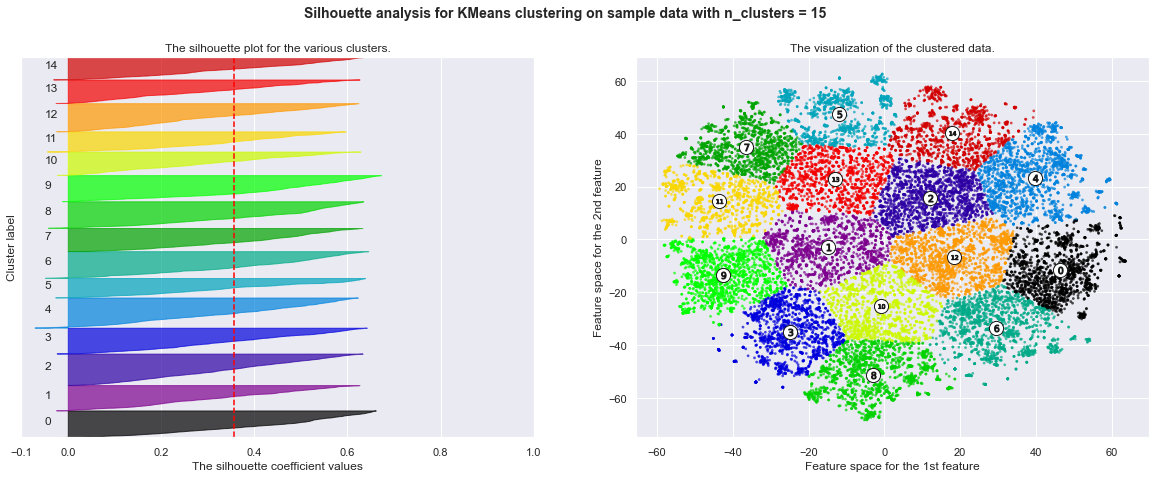

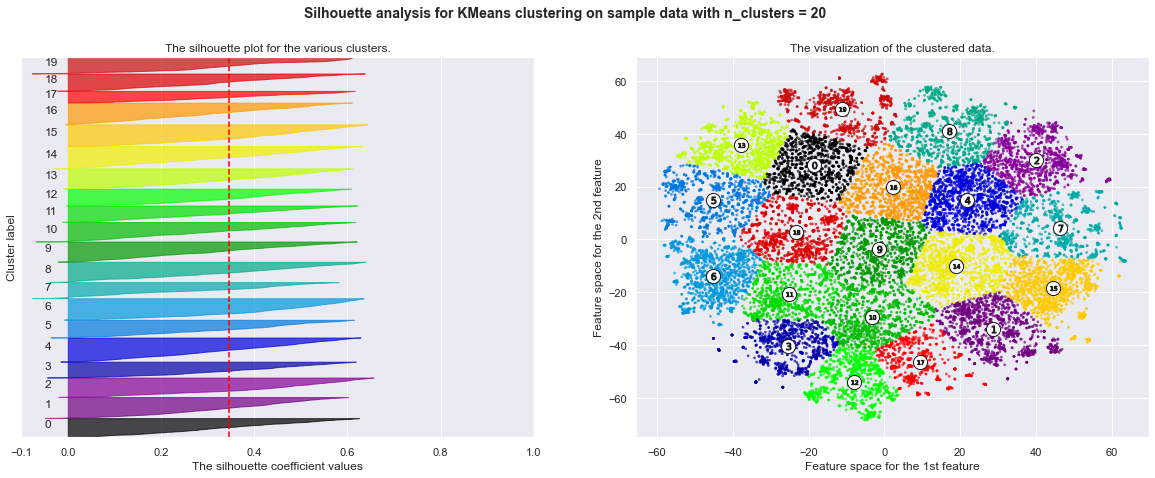

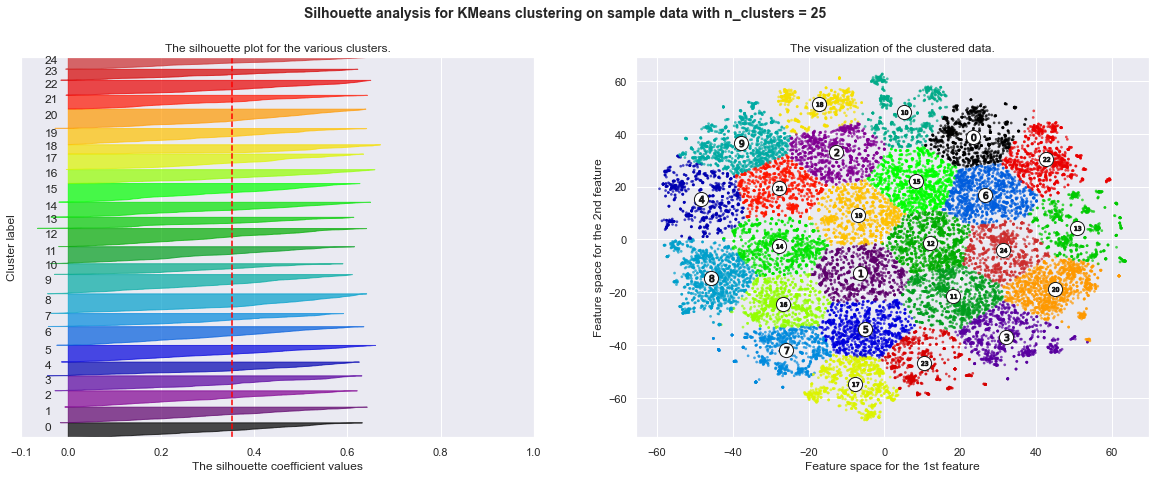

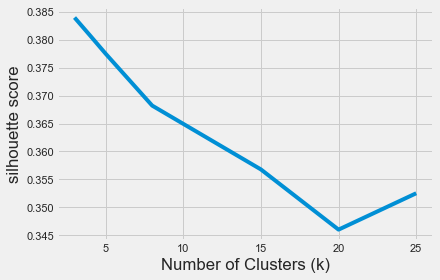

In [115]:
silhouette_method_eval(low_dim_Z[sample], cluster_method = KMeans, range_n_clusters=[3, 4, 5, 8, 15, 20, 25])

Given our visualizations lets explore the clusters of not so aggresively reduced TF-IDF - Now time for the real clustering!

In [ ]:
%time data_TSNE = TruncatedSVD(n_components=500).fit_transform(train_tfidf)

In [ ]:
silhouettes_agg = []
silhouettes_kmeans = []

K = range(3, 20)

for c in K:
    agg_clustering = AgglomerativeClustering(n_clusters=c)
    agg_cluster_ids = agg_clustering.fit_predict(data_TSNE)

    kmeans_clustering = KMeans(init='k-means++', n_clusters=c, n_init=10)
    kmeans_ids = kmeans_clustering.fit_predict(data_TSNE)
    
    score_a = silhouette_score(data_TSNE, agg_cluster_ids)
    score_k = silhouette_score(data_TSNE, kmeans_ids)
    
    silhouettes_agg.append(score_a)
    silhouettes_kmeans.append(score_k)
    print(c, 'Agg {}'.format(score_a), 'Kmeans {}'.format(score_k))

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(K, silhouettes_agg, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method For Optimal k')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(K, silhouettes_kmeans, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method For Optimal k')
plt.show()

20 Kmeans 0.01970258054366088
21 Kmeans 0.02123014954300573
22 Kmeans 0.02077281552527802
23 Kmeans 0.02254433166696275
24 Kmeans 0.021386098680188363
25 Kmeans 0.021865097968061947
26 Kmeans 0.022025092843158733
27 Kmeans 0.022782873305018055
28 Kmeans 0.022663733421808614
29 Kmeans 0.021878596285784303


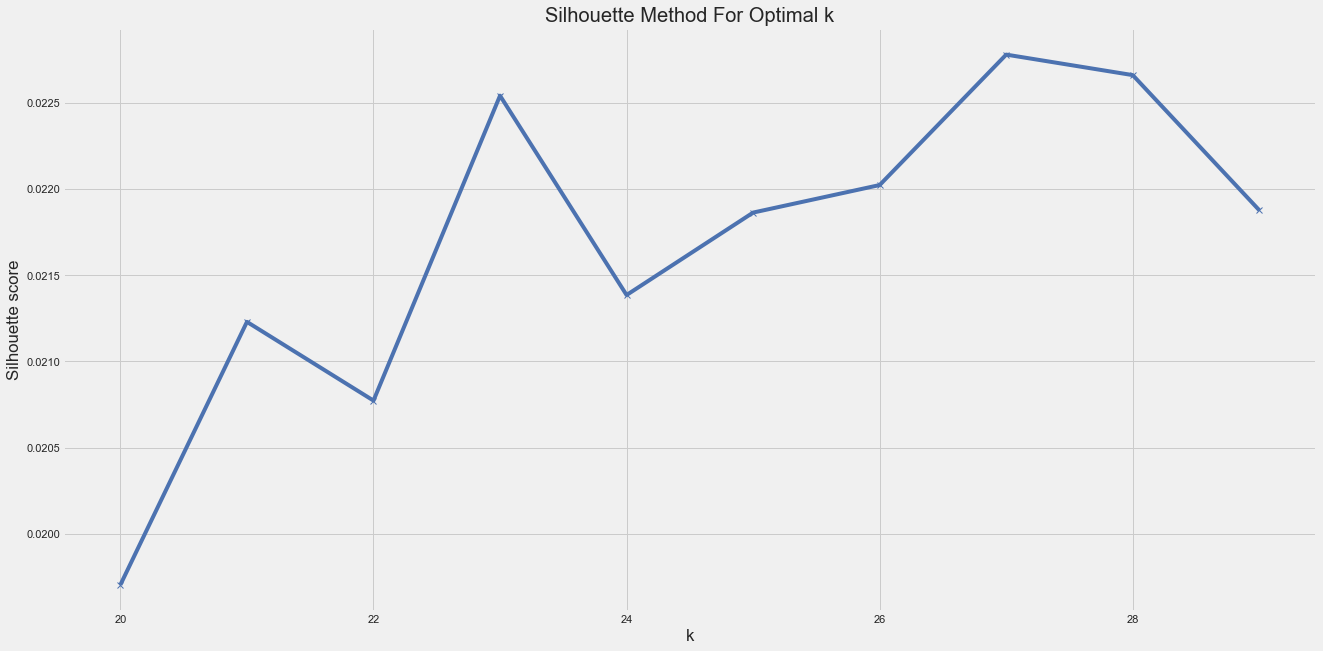

In [160]:
# From the previous run we can see that Kmeans gives us better silhouette scores
# furthermore it never peaked so lets explore the 20 to 30 range
silhouettes_kmeans = []

K = range(20, 30)

for c in K:
    kmeans_clustering = KMeans(init='k-means++', n_clusters=c, n_init=10)
    kmeans_ids = kmeans_clustering.fit_predict(train_tfidf)
    
    score_k = silhouette_score(train_tfidf, kmeans_ids)
    
    silhouettes_kmeans.append(score_k)
    print(c, 'Kmeans {}'.format(score_k))

fig, ax = plt.subplots(figsize=(20,10))
plt.plot(K, silhouettes_kmeans, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method For Optimal k')
plt.show()

We can see that the score peaks at 23 clusters, which makes sense as it is around the number of cuisines we have in the dataset!

## 4. Prediction


### 4.1 Classification
The classification problem icludes all of the following:

1. a most-frequent-label baseline
2. a `LogisticRegression()` baseline with default parameters and 2-6 gram character TFIDF features 
3. Support Vector Machine model
4. two bootstrap sampling significance tests of the performance difference between your best model and each of the two baselines

### 4.1 Structured Prediction 
The structured prediction problem includes all of the following:

1. Structured Perceptron adapted from Collins 2002 to establish baseline performance
2. Bi_LSTM neural net implemented in `keras` functional API
3. Performance comparisson

In [10]:
# Before we move on to prediction we need to split our data into a train, dev and test sets 
from sklearn.model_selection import train_test_split
from ast import literal_eval

# Now we split the data into train, dev, test - 60/20/20
train_c, test_c = train_test_split(df, test_size=0.2, random_state=1, shuffle=True)
train_c, dev_c = train_test_split(train_c, test_size=0.25, random_state=1, shuffle=True)

In [11]:
print(len(train_c), len(dev_c), len(test_c))

23864 7955 7955


In [12]:
target = 'cuisine'

y_train = train_c[target]
# transform dev and test with the same label converter
y_dev = dev_c[target]
y_test = test_c[target]

print(y_train[:10])

38449     vietnamese
15634        italian
21406    southern_us
1410         chinese
15047        italian
27633          greek
10979         indian
11105        mexican
20291        chinese
35250       japanese
Name: cuisine, dtype: object


In [13]:
X_train = tfidf_vectorizer.fit_transform(train_c.ingredients.apply(lambda x: ' '.join(x)).tolist())
print(X_train.shape)

X_dev = tfidf_vectorizer.transform(dev_c.ingredients.apply(lambda x: ' '.join(x)).tolist())
X_test = tfidf_vectorizer.transform(test_c.ingredients.apply(lambda x: ' '.join(x)).tolist())
print(X_dev.shape, X_test.shape)

(23864, 1873)
(7955, 1873) (7955, 1873)


In [68]:
# We need to keep in mind that our classes are imbalanced 
# First lets establish a dummy baseline

# find the most frequent class in the training data -- Italian
most_frequent = DummyClassifier(strategy='most_frequent')
most_frequent.fit(X_train, y_train)

# get the performance on the development set
dumb_predictions = most_frequent.predict(X_dev)

print(classification_report(y_dev, dumb_predictions))

/home/dimitar/miniconda3/envs/nlp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dimitar/miniconda3/envs/nlp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

   brazilian       0.00      0.00      0.00        92
     british       0.00      0.00      0.00       188
cajun_creole       0.00      0.00      0.00       328
     chinese       0.00      0.00      0.00       544
    filipino       0.00      0.00      0.00       141
      french       0.00      0.00      0.00       519
       greek       0.00      0.00      0.00       237
      indian       0.00      0.00      0.00       597
       irish       0.00      0.00      0.00       151
     italian       0.19      1.00      0.32      1534
    jamaican       0.00      0.00      0.00       101
    japanese       0.00      0.00      0.00       295
      korean       0.00      0.00      0.00       178
     mexican       0.00      0.00      0.00      1260
    moroccan       0.00      0.00      0.00       144
     russian       0.00      0.00      0.00       101
 southern_us       0.00      0.00      0.00       890
     spanish       0.00    

/home/dimitar/miniconda3/envs/nlp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [69]:
classifier = LogisticRegression(n_jobs=4, multi_class='auto', solver='lbfgs')
%time classifier.fit(X_train, y_train)
print(classifier)

CPU times: user 126 ms, sys: 400 ms, total: 526 ms
Wall time: 7.18 s
LogisticRegression(n_jobs=4)


/home/dimitar/miniconda3/envs/nlp/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [70]:
predictions = classifier.predict(X_dev)
print(predictions[:10])
print(classification_report(y_dev,predictions))

['italian' 'indian' 'greek' 'indian' 'cajun_creole' 'mexican'
 'southern_us' 'southern_us' 'thai' 'southern_us']
              precision    recall  f1-score   support

   brazilian       0.85      0.55      0.67        92
     british       0.63      0.30      0.41       188
cajun_creole       0.80      0.68      0.74       328
     chinese       0.76      0.86      0.81       544
    filipino       0.72      0.54      0.62       141
      french       0.56      0.60      0.58       519
       greek       0.83      0.62      0.71       237
      indian       0.86      0.91      0.89       597
       irish       0.76      0.49      0.60       151
     italian       0.76      0.90      0.83      1534
    jamaican       0.88      0.68      0.77       101
    japanese       0.85      0.66      0.75       295
      korean       0.82      0.65      0.73       178
     mexican       0.91      0.93      0.92      1260
    moroccan       0.81      0.71      0.76       144
     russian       0.6

In [123]:
# Now lets try to improve this 
# setting up the classifier we want to optimize
base_clf = LogisticRegression(n_jobs=4)

# defining parameters to optimize
param_grid = {'C': [20, 10, 5, 1, 0.01],
              'class_weight': ['balanced', None]
             }
# run the optimization
search = GridSearchCV(base_clf, # use the classifier defined above
                      param_grid, # use the parameters defined above
                      cv=5, # use 5-fold cross validation
                      scoring='f1_micro') # use micro F1 to select best model
search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(n_jobs=4),
             param_grid={'C': [20, 10, 5, 1, 0.01],
                         'class_weight': ['balanced', None]},
             scoring='f1_micro')

In [125]:
# Now we can se which one is the best combiation 
clf_best_l = search.best_estimator_
print(clf_best_l.get_params(), search.best_score_)

# fit this classifier on the entire training data, instead of CV
clf_best_l.fit(X_train, y_train)

{'C': 5, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': 4, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False} 0.778829794725816


LogisticRegression(C=5, n_jobs=4)

In [126]:
predictions_Log = clf_best.predict(X_dev)
print(classification_report(y_dev,predictions_Log))

              precision    recall  f1-score   support

   brazilian       0.82      0.68      0.75        92
     british       0.61      0.40      0.49       188
cajun_creole       0.77      0.71      0.74       328
     chinese       0.77      0.86      0.81       544
    filipino       0.74      0.61      0.67       141
      french       0.58      0.61      0.59       519
       greek       0.82      0.68      0.74       237
      indian       0.87      0.91      0.89       597
       irish       0.68      0.58      0.63       151
     italian       0.80      0.89      0.84      1534
    jamaican       0.81      0.73      0.77       101
    japanese       0.84      0.67      0.75       295
      korean       0.81      0.71      0.75       178
     mexican       0.92      0.92      0.92      1260
    moroccan       0.81      0.74      0.78       144
     russian       0.65      0.41      0.50       101
 southern_us       0.72      0.81      0.76       890
     spanish       0.62    

Now the model that I have decided to use is Support Vector Machine, this architecture has been shown to produce similiar results to CNN (where CNN and SVM are top tier NLP classification models). On top of that the easy integration of SVM into sklearn makes hyper-parameter otimization more straightforward. Finally it gives us a chance to explore an additional architecture!

In [14]:
# Lets star with a linear SVM
svc_classifier = LinearSVC(class_weight='balanced')
%time svc_classifier.fit(X_train, y_train)
print(svc_classifier)

CPU times: user 2.26 s, sys: 3.96 ms, total: 2.26 s
Wall time: 2.28 s
LinearSVC(class_weight='balanced')


In [15]:
predictions = svc_classifier.predict(X_dev)
print(classification_report(y_dev,predictions))

              precision    recall  f1-score   support

   brazilian       0.54      0.76      0.63        92
     british       0.50      0.53      0.51       188
cajun_creole       0.74      0.76      0.75       328
     chinese       0.80      0.82      0.81       544
    filipino       0.60      0.65      0.62       141
      french       0.58      0.58      0.58       519
       greek       0.68      0.76      0.72       237
      indian       0.89      0.89      0.89       597
       irish       0.49      0.60      0.54       151
     italian       0.88      0.81      0.85      1534
    jamaican       0.67      0.79      0.73       101
    japanese       0.81      0.66      0.73       295
      korean       0.72      0.80      0.76       178
     mexican       0.95      0.90      0.92      1260
    moroccan       0.69      0.80      0.74       144
     russian       0.40      0.54      0.46       101
 southern_us       0.79      0.75      0.77       890
     spanish       0.48    

In [295]:
param_grid = {'C': [0.001, 0.1, 1, 10, 50, 100, 500, 1000, 5000],  
              'penalty': ['l1','l2'],
              'loss': ['hinge','squared hinge'],
              'class_weight': ['balanced', None]} 

grid = GridSearchCV(LinearSVC(), 
                    param_grid, 
                    refit = True, 
                    verbose = 3, 
                    n_jobs=4, 
                    scoring='f1_micro')

grid.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


C:\Users\User\anaconda3\envs\nlp\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.71496777        nan        nan        nan 0.6341769
        nan        nan        nan 0.73323816        nan        nan
        nan 0.73487263        nan        nan        nan 0.75988911
        nan        nan        nan 0.77442996        nan        nan
        nan 0.74396551        nan        nan        nan 0.76357681
        nan        nan        nan 0.72339076        nan        nan
        nan 0.74543222        nan        nan        nan 0.71421374
        nan        nan        nan 0.73851794        nan        nan
        nan 0.69606928        nan        nan        nan 0.71752425
        nan        nan        nan 0.68655663        nan        nan
        nan 0.70482719        nan        nan        nan 0.66606647
        nan        nan        nan 0.68500599        nan        nan]
  warnings.warn(
C:\Users\User\anaconda3\envs

GridSearchCV(estimator=LinearSVC(), n_jobs=4,
             param_grid={'C': [0.001, 0.1, 1, 10, 50, 100, 500, 1000, 5000],
                         'class_weight': ['balanced', None],
                         'loss': ['hinge', 'squared hinge'],
                         'penalty': ['l1', 'l2']},
             scoring='f1_micro', verbose=3)

In [296]:
linSVC_best = search.best_estimator_
print(grid.best_params_)

# fit this classifier on the entire training data, instead of CV
linSVC_best.fit(X_train, y_train)
predictions = linSVC_best.predict(X_dev)
print(classification_report(y_dev,predictions))

{'C': 1, 'class_weight': None, 'loss': 'hinge', 'penalty': 'l2'}
              precision    recall  f1-score   support

   brazilian       0.82      0.68      0.75        92
     british       0.61      0.40      0.49       188
cajun_creole       0.77      0.71      0.74       328
     chinese       0.77      0.86      0.81       544
    filipino       0.74      0.61      0.67       141
      french       0.58      0.61      0.59       519
       greek       0.82      0.68      0.74       237
      indian       0.87      0.91      0.89       597
       irish       0.68      0.58      0.63       151
     italian       0.80      0.89      0.84      1534
    jamaican       0.81      0.73      0.77       101
    japanese       0.84      0.67      0.75       295
      korean       0.81      0.71      0.75       178
     mexican       0.92      0.92      0.92      1260
    moroccan       0.81      0.74      0.78       144
     russian       0.65      0.41      0.50       101
 southern_us    

We know from our clustering and data visualization that it shows nonlinear trends therefore a non linear SVM should give better resutls!

In [300]:
# Furthermore I will utiliza Baysian Optimization to explore the whole hyper-parameter space efficiently
def SVC_eval(C, gamma):
    # We use a balanced class weight to control for our unbalanceed classes
    s = SVC(C=float(C), gamma=float(gamma), kernel='rbf', class_weight='balanced') 
    f = cross_val_score(s, X_train, y_train, cv=5, scoring='f1_micro')
    return f.max()

optimizer = BayesianOptimization(SVC_eval, {'C': (0.1, 1000),  
                                          'gamma': (0.0001, 1),
                                        })

In [301]:
%%time
optimizer.maximize(n_iter=15, init_points=3) 

print(optimizer.max)

|   iter    |  target   |     C     |   gamma   |
-------------------------------------------------
|  1        |  0.7878   |  573.1    |  0.3577   |
|  2        |  0.7591   |  529.7    |  0.06458  |
|  3        |  0.7486   |  375.2    |  0.002933 |
|  4        |  0.7972   |  574.1    |  0.6158   |
|  5        |  0.7651   |  577.5    |  0.1132   |
|  6        |  0.8039   |  569.0    |  0.9736   |
|  7        |  0.7746   |  567.3    |  0.1876   |
|  8        |  0.7913   |  570.1    |  0.4298   |
|  9        |  0.8018   |  24.73    |  0.8815   |
|  10       |  0.7961   |  26.24    |  0.4835   |
|  11       |  0.7381   |  23.0     |  0.009559 |
|  12       |  0.7951   |  27.69    |  0.5589   |
|  13       |  0.7832   |  29.34    |  0.2386   |
|  14       |  0.7612   |  575.3    |  0.0898   |
|  15       |  0.7712   |  25.28    |  0.1545   |
|  16       |  0.7953   |  823.5    |  0.5634   |
|  17       |  0.7972   |  823.5    |  0.6172   |
|  18       |  0.7871   |  569.2    |  0.341    |


In [16]:
C = float(569.0071805160467)
gamma = float(0.9735625933651026)

best_clf = SVC(C=C, gamma=gamma, kernel='rbf', class_weight='balanced')
%time best_clf.fit(X_train, y_train)

CPU times: user 2min 7s, sys: 179 ms, total: 2min 7s
Wall time: 2min 8s


SVC(C=569.0071805160467, class_weight='balanced', gamma=0.9735625933651026)

In [17]:
# It looks liek our SVM has done slightly better compared to our 
# HULK baseline (Logistic modelw ith regularization)

# To make sure that is the case we need to do significance testing using bootstrap
predictions_svm = best_clf.predict(X_dev)
print(classification_report(y_dev,predictions_svm))

              precision    recall  f1-score   support

   brazilian       0.77      0.68      0.72        92
     british       0.63      0.46      0.53       188
cajun_creole       0.79      0.73      0.76       328
     chinese       0.77      0.88      0.82       544
    filipino       0.79      0.66      0.72       141
      french       0.59      0.63      0.61       519
       greek       0.86      0.70      0.77       237
      indian       0.88      0.90      0.89       597
       irish       0.66      0.54      0.60       151
     italian       0.79      0.90      0.85      1534
    jamaican       0.87      0.71      0.78       101
    japanese       0.83      0.69      0.75       295
      korean       0.88      0.72      0.79       178
     mexican       0.92      0.93      0.92      1260
    moroccan       0.82      0.78      0.80       144
     russian       0.75      0.43      0.54       101
 southern_us       0.74      0.81      0.77       890
     spanish       0.67    

In [18]:
pickle.dump((tfidf_vectorizer, best_clf), open('models/SVM_classification.pickle','wb'))

In [134]:
# Significance testing 

import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

def bootstrap_sample(system1, system2, gold, samples=1000, score=f1_score, average='micro'):
    """
    compute the proportion of times the performance difference of the 
    two systems on a subsample is significantly different from the 
    performance on the entire sample
    """
    N = len(gold) # number of instances
    
    # make sure the two systems have the same number of samples
    assert len(system1) == N and len(system2) == N, 'samples have different lengths'

    # compute performance score on entire sample
    base_score1 = score(gold, system1, average=average)
    base_score2 = score(gold, system2, average=average)
    print("Base difference: {} vs. {}".format(base_score1, base_score2))

    # switch systems if system2 is better
    if base_score2 > base_score1:
        system1, system2 = system2, system1
        base_score1, base_score2 = base_score2, base_score1
    
    # compute the difference
    basedelta = base_score1 - base_score2
    assert basedelta > 0, 'Wrong system first, system1 needs to be better!'

    system1 = np.array(system1)
    system2 = np.array(system2)
    gold = np.array(gold)

    p = 0
    deltas = []
    for i in range(samples):
        # select a subsample, with replacement
        sample = np.random.choice(N, size=N, replace=True)

        # collect data corresponding to subsample
        sample1 = system1[sample]
        sample2 = system2[sample]
        gold_sample = gold[sample]

        # compute scores on subsample
        sample_score1 = score(gold_sample, sample1, average=average)
        sample_score2 = score(gold_sample, sample2, average=average)
        sample_delta = sample_score1 - sample_score2

        # check whether the observed sample difference is at least 
        # twice as large as the base difference
        if sample_delta > 2*basedelta:
            p += 1
        deltas.append(sample_delta)
                
    return p/samples, deltas

Base difference: 0.8002514142049025 vs. 0.7835323695788812
0.0 True


<AxesSubplot:ylabel='Frequency'>

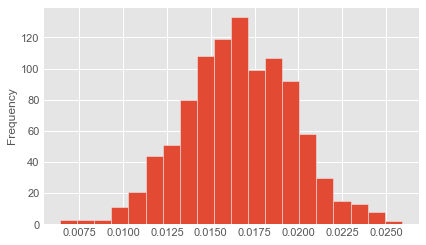

In [136]:
# As we can see out SVM model is statistically significant better than the Log at 0,01 level
p_value, deltas = bootstrap_sample(predictions_svm, predictions_Log, y_dev)
print(p_value, p_value < 0.01)

%matplotlib inline
plt.style.use('ggplot')
pd.Series(deltas).plot.hist(bins=20)

## Now lets implement a Structured Prediction 

Now that we have a classifier that can predict cuisine based on ingredients we need to extract the ingredients from our raw recipies.

To do that we can either create sophisticated rules based on patterns we see, which might yield fair results but is time consuming and extremely unflexible *OR* we can train a structured prediction NER model to recognize ingredients! 


In [6]:
df = pd.read_csv('data/NER_data.csv')
df.head()

Unnamed: 0  index                                              input  \
0           0      0  1 1/4 cups cooked and pureed fresh butternut s...   
1           1      1  1 cup peeled and cooked fresh chestnuts (about...   
2           2      2            1 medium-size onion, peeled and chopped   
3           3      3                    2 stalks celery, chopped coarse   
4           4      4                    1 1/2 tablespoons vegetable oil   

               name   qty  range_end        unit  \
0  butternut squash  1.25        0.0         cup   
1         chestnuts  1.00        0.0         cup   
2             onion  1.00        0.0         NaN   
3            celery  2.00        0.0       stalk   
4     vegetable oil  1.50        0.0  tablespoon   

                                             comment  \
0  cooked and pureed fresh, or 1 10-ounce package...   
1  peeled and cooked fresh (about 20), or 1 cup c...   
2                    medium-size, peeled and chopped   
3                                     chopped coarse   
4                                                NaN   

                                     input_tokenized           name_tokenized  \
0  ['1', '1/4', 'cups', 'cooked', 'and', 'pureed'...  ['butternut', 'squash']   
1  ['1', 'cup', 'peeled', 'and', 'cooked', 'fresh...            ['chestnuts']   
2  ['1', 'medium', '-', 'size', 'onion', ',', 'pe...                ['onion']   
3  ['2', 'stalks', 'celery', ',', 'chopped', 'coa...               ['celery']   
4    ['1', '1/2', 'tablespoons', 'vegetable', 'oil']     ['vegetable', 'oil']   

                                        tagged_input  
0  [('1', 'O'), ('1/4', 'O'), ('cups', 'O'), ('co...  
1  [('1', 'O'), ('cup', 'O'), ('peeled', 'O'), ('...  
2  [('1', 'O'), ('medium', 'O'), ('-', 'O'), ('si...  
3  [('2', 'O'), ('stalks', 'O'), ('celery', 'B - ...  
4  [('1', 'O'), ('1/2', 'O'), ('tablespoons', 'O'...

In [7]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=1, shuffle=True)
train_df, dev_df = train_test_split(train_df, test_size=0.25, random_state=1, shuffle=True)

# Train Data
words = [[word  for word, tag in literal_eval(tup)] for tup in train_df.tagged_input]
tags = [[tag  for word, tag in literal_eval(tup)] for tup in train_df.tagged_input]

train_NER = list(zip(words, tags))

# Dev Data
words = [[word  for word, tag in literal_eval(tup)] for tup in dev_df.tagged_input]
tags = [[tag  for word, tag in literal_eval(tup)] for tup in dev_df.tagged_input]

dev_NER = list(zip(words, tags))

# Test Data
words = [[word  for word, tag in literal_eval(tup)] for tup in test_df.tagged_input]
tags = [[tag  for word, tag in literal_eval(tup)] for tup in test_df.tagged_input]

test_NER = list(zip(words, tags))

In [8]:
print('Train instances: \t\t{}'.format(len(train_NER)))
print('Development instances: \t\t{}'.format(len(dev_NER)))
print('Test instances: \t\t{}'.format(len(test_NER)))

Train instances: 		106295
Development instances: 		35432
Test instances: 		35432


In [9]:
# Now lest see how our labels are distributed accross datasets
print('Train \t\t',collections.Counter([tag for words, tags in train_NER for tag in tags]).most_common())
print('Dev \t\t',collections.Counter([tag for words, tags in dev_NER for tag in tags]).most_common())
print('Test \t\t',collections.Counter([tag for words, tags in test_NER for tag in tags]).most_common())

Train 		 [('O', 485884), ('B - INGREDIENT', 112418), ('I - INGREDIENT', 92558)]
Dev 		 [('O', 162004), ('B - INGREDIENT', 37454), ('I - INGREDIENT', 30611)]
Test 		 [('O', 162445), ('B - INGREDIENT', 37357), ('I - INGREDIENT', 31137)]


In [6]:
from structured_perceptron import StructuredPerceptron

In [7]:
sp = StructuredPerceptron()
inference_method = 'viterbi'
%time sp.fit(train_NER, dev_NER, iterations=10, inference=inference_method)

Iteration 1
***************
	Current F-score: 0.24

.................................................10000
	Current F-score: 0.72

.................................................20000
	Current F-score: 0.73

.................................................30000
	Current F-score: 0.73

.................................................40000
	Current F-score: 0.73

.................................................50000
	Current F-score: 0.73

.................................................60000
	Current F-score: 0.73

.................................................70000
	Current F-score: 0.73

.................................................80000
	Current F-score: 0.73

.................................................90000
	Current F-score: 0.73

.................................................100000
	Current F-score: 0.73

...............................	203800 features
	Training F-score: 0.73

	Development F-score: 0.73

Iteration 2
***************
	Current F-score: 0.78

....

CPU times: user 49min 40s, sys: 17.5 s, total: 49min 57s
Wall time: 49min 27s


In [8]:
print(sp.results_summary(test_NER, method=inference_method))
sp.save('models/model_v.pickle')

                precision    recall  f1-score   support

B - INGREDIENT       0.71      0.72      0.72     37357
I - INGREDIENT       0.58      0.57      0.57     31137
             O       0.91      0.91      0.91    162445

      accuracy                           0.83    230939
     macro avg       0.73      0.73      0.73    230939
  weighted avg       0.83      0.83      0.83    230939



saving model... done


In [9]:
sp2 = StructuredPerceptron()
inference_method = 'greedy'
%time sp2.fit(train_NER, dev_NER, iterations=10, inference=inference_method)

Iteration 1
***************
	Current F-score: 0.25

.................................................10000
	Current F-score: 0.73

.................................................20000
	Current F-score: 0.74

.................................................30000
	Current F-score: 0.74

.................................................40000
	Current F-score: 0.75

.................................................50000
	Current F-score: 0.75

.................................................60000
	Current F-score: 0.75

.................................................70000
	Current F-score: 0.75

.................................................80000
	Current F-score: 0.75

.................................................90000
	Current F-score: 0.76

.................................................100000
	Current F-score: 0.76

...............................	204031 features
	Training F-score: 0.76

	Development F-score: 0.79

Iteration 2
***************
	Current F-score: 0.13

....

CPU times: user 17min 57s, sys: 9.84 s, total: 18min 7s
Wall time: 18min 6s


In [10]:
print(sp2.results_summary(test_NER, method=inference_method))
sp2.save('models/model_g.pickle')

                precision    recall  f1-score   support

B - INGREDIENT       0.82      0.85      0.84     37357
I - INGREDIENT       0.83      0.61      0.71     31137
             O       0.93      0.97      0.95    162445

      accuracy                           0.90    230939
     macro avg       0.86      0.81      0.83    230939
  weighted avg       0.90      0.90      0.90    230939



saving model... done


#### Bi-LSTM

I have opted to use a Bi-LSTM as it has been show to have better results due to better context understanding. Since  it preserves information both from the past and the future. Furthermore that makes it a better comparison to our structured perptron model which aso takes subsequent words as features.

In [10]:
train_instances = [(words, tags) for (words, tags) in train_NER]
test_instances = [(words, tags) for (words, tags) in test_NER]
dev_instances = [(words, tags) for (words, tags) in dev_NER]

#### Converting the data in an appropriate format

In [11]:
# collect known word tokens and tags
wordset, tagset = set(), set()
for (words, tags) in train_instances:
    tagset.update(set(tags))
    wordset.update(set(words))

# map words and tags into ints
PAD = '-PAD-'
UNK = '-UNK-'
word2int = {word: i + 2 for i, word in enumerate(sorted(wordset))}
word2int[PAD] = 0  # special token for padding
word2int[UNK] = 1  # special token for unknown words
 
tag2int = {tag: i + 1 for i, tag in enumerate(sorted(tagset))}
tag2int[PAD] = 0
# to translate it back
int2tag = {i:tag for tag, i in tag2int.items()}


def convert2ints(instances):
    result = []
    for (words, tags) in instances:
        # replace words with int, 1 for unknown words
        word_ints = [word2int.get(word, 1) for word in words]
        # replace tags with int
        tag_ints = [tag2int[tag] for tag in tags]
        result.append((word_ints, tag_ints))
    return result        

In [12]:
# apply integer mapping
train_instances_int = convert2ints(train_instances)
dev_instances_int = convert2ints(dev_instances)
test_instances_int = convert2ints(test_instances)

# separate the words from the tags
train_sentences, train_tags = zip(*train_instances_int) 
dev_sentences, dev_tags = zip(*dev_instances_int)
test_sentences, test_tags = zip(*test_instances_int) 

print(train_instances[0][0])
print(train_sentences[0])
print(train_instances[0][1])
print(train_tags[0])

qu_calc = sorted([len(l[0]) for l in train_instances_int])
MAX_LENGTH = int(np.percentile(qu_calc, 99))
print(MAX_LENGTH)

['1', 'pint', 'brussels', 'sprouts', '(', 'about', 'a', 'pound', ')']
[51, 5861, 2836, 7339, 15, 2316, 2312, 5987, 16]
['O', 'O', 'B - INGREDIENT', 'I - INGREDIENT', 'O', 'O', 'O', 'O', 'O']
[3, 3, 1, 2, 3, 3, 3, 3, 3]
22


In [13]:
#collect known words and tags
prefixset = set([w[:3] for words, _ in train_instances for w in words])
suffixset = set([w[-3:] for words, _ in train_instances for w in words])

# map words and tags into ints
PAD = '-PAD-'
UNK = '-UNK-'
prefix2int = {prefix: i + 2 for i, prefix in enumerate(sorted(prefixset))}
suffix2int = {suffix: i + 2 for i, suffix in enumerate(sorted(suffixset))}
prefix2int[PAD] = 0  # special token for padding
prefix2int[UNK] = 1  # special token for unknown words
suffix2int[PAD] = 0  # special token for padding
suffix2int[UNK] = 1  # special token for unknown words

def convert2ints_pre_suf(instances):
    result = []
    for (words, _) in instances:
        # replace prefixes with int, 1 for unknown words
        prefix_ints = [prefix2int.get(word[:3], 1) for word in words]
        # replace suffixes
        suffix_ints = [suffix2int.get(word[-3:], 1) for word in words]
        result.append((prefix_ints, suffix_ints))
    
    return result

train_prefix, train_suffix = zip(*convert2ints_pre_suf(train_instances))
dev_prefix, dev_suffix = zip(*convert2ints_pre_suf(dev_instances))
test_prefix, test_suffix = zip(*convert2ints_pre_suf(test_instances))

# Padding
train_prefix = pad_sequences(train_prefix, maxlen=MAX_LENGTH, padding='post')
train_suffix = pad_sequences(train_suffix, maxlen=MAX_LENGTH, padding='post')
dev_prefix = pad_sequences(dev_prefix, maxlen=MAX_LENGTH, padding='post')

dev_suffix = pad_sequences(dev_suffix, maxlen=MAX_LENGTH, padding='post')
test_prefix = pad_sequences(test_prefix, maxlen=MAX_LENGTH, padding='post')
test_suffix = pad_sequences(test_suffix, maxlen=MAX_LENGTH, padding='post')

train_sentences = pad_sequences(train_sentences, maxlen=MAX_LENGTH, padding='post')
dev_sentences = pad_sequences(dev_sentences, maxlen=MAX_LENGTH, padding='post')
test_sentences = pad_sequences(test_sentences, maxlen=MAX_LENGTH, padding='post')

train_tags = pad_sequences(train_tags, maxlen=MAX_LENGTH, padding='post')
dev_tags = pad_sequences(dev_tags, maxlen=MAX_LENGTH, padding='post')
test_tags = pad_sequences(test_tags, maxlen=MAX_LENGTH, padding='post')

In [15]:
## Now F1-score is better measurement to track when there is imbalance in the class distribution
# From previous exploratory stats we know that the 'O' tag is much more represneted then the rest

# define a metric function to compute F-score
import tensorflow as tf

@tf.autograph.experimental.do_not_convert # decorator used to tell keras this is a custom metric

def f1_multiclass(y_true, y_pred):
    """
    Compute the F-score for multiclass labels
    """

    y_true = y_true.numpy()
    y_pred = y_pred.numpy()
    
    y_true_arg = y_true.argmax(axis=2)
    y_pred_arg = y_pred.argmax(axis=2)
    
    f1s = np.zeros((y_true.shape[-1]))
    
    for i in range(y_true.shape[2]):
        tp = np.sum(np.logical_and((y_true_arg == i), (y_pred_arg == i)))
        fp = np.sum(np.logical_and((y_true_arg != i), (y_pred_arg == i)))
        fn = np.sum(np.logical_and((y_true_arg == i), (y_pred_arg != i)))

        precision = tp / (tp+fp+np.finfo(float).eps)
        recall = tp / (tp+fn+np.finfo(float).eps)
        f1s[i] = 2*((precision*recall)/(precision+recall+np.finfo(float).eps))
        
    return round(f1s.mean(), 2)

# define a custom weighted cross entropy to account for the fact that the dataset is unbalanced
def weighted_categorical_crossentropy(train_tags):
    
    c_tags = Counter(train_tags.ravel())
    tot = np.sum(list(c_tags.values()))
    class_weights = {it: np.exp(np.log(val/tot)*(-1)/2) for (it, val) in c_tags.items()}
    weights = [el for k, el in sorted(class_weights.items())]
    
    def wcce(y_true, y_pred):
        Kweights = K.constant(weights)
        if not K.is_keras_tensor(y_pred): 
            y_pred = K.constant(y_pred)
        y_true = K.cast(y_true, y_pred.dtype)
        return K.categorical_crossentropy(y_true, y_pred) * K.sum(y_true * Kweights, axis=-1)
    
    return wcce

In [16]:
train_tags_1hot = to_categorical(train_tags, len(tag2int))
dev_tags_1hot = to_categorical(dev_tags, len(tag2int))
test_tags_1hot = to_categorical(test_tags, len(tag2int))


print(train_tags[0], end=' / ')
print(train_tags_1hot[0].shape)
print(train_tags_1hot[0])

[3 3 1 2 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0] / (22, 4)
[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


In [19]:
validation_data = ([dev_sentences, dev_prefix, dev_suffix], dev_tags_1hot)

In [18]:
np.random.seed(123)

inputs_w = Input((MAX_LENGTH, ), 
               name='word_IDs')
embeddings = Embedding(input_dim=len(word2int), 
                       output_dim=300,
                       mask_zero=False,
                       name='embeddings')(inputs_w)

inputs_pre = Input((MAX_LENGTH, ), 
               name='prefix_IDs')
embeddings_pre = Embedding(input_dim=len(prefix2int),
                       output_dim=22,
                       mask_zero=False,
                       name='embeddings_prefix')(inputs_pre)

inputs_suf = Input((MAX_LENGTH, ), 
               name='suffix_IDs')
embeddings_suf = Embedding(input_dim=len(suffix2int),
                       output_dim=22,
                       mask_zero=False,
                       name='embeddings_suffix')(inputs_suf)

concat = Concatenate(name="concatenate")([embeddings, embeddings_pre, embeddings_suf])

bilstm = Bidirectional(LSTM(units=256, 
                            return_sequences=True), 
                       name="Bi-LSTM")(concat)
dropout = Dropout(0.3, name='dropout')(bilstm)
bilstm_out = Dense(len(tag2int), name='inter_output')(dropout)
output = Activation('softmax', name='softmax')(bilstm_out)

model = Model(inputs=[inputs_w, inputs_pre, inputs_suf], outputs=[output], name="DVD")
model.summary()

2022-02-09 18:58:42.723454: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-09 18:58:43.438530: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1726 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1


Model: "DVD"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
word_IDs (InputLayer)           [(None, 22)]         0                                            
__________________________________________________________________________________________________
prefix_IDs (InputLayer)         [(None, 22)]         0                                            
__________________________________________________________________________________________________
suffix_IDs (InputLayer)         [(None, 22)]         0                                            
__________________________________________________________________________________________________
embeddings (Embedding)          (None, 22, 300)      2494500     word_IDs[0][0]                   
________________________________________________________________________________________________

In [19]:
batch_size = 256
epochs = 10

# compile the model we have defined above
model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=[f1_multiclass], #, f1, 
              run_eagerly=True)

# run training and capture ouput log
history = model.fit([train_sentences, train_prefix, train_suffix], train_tags_1hot,
                    batch_size=batch_size,
                    validation_data=validation_data,
                    epochs=epochs,
                    verbose=1)

2022-02-09 18:59:48.993250: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 37415840 exceeds 10% of free system memory.
2022-02-09 18:59:49.053962: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 37415840 exceeds 10% of free system memory.
2022-02-09 18:59:49.098990: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-02-09 18:59:49.713834: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101


416/416 [==============================] - 30s 70ms/step - loss: 0.1333 - f1_multiclass: 0.7904 - val_loss: 0.0790 - val_f1_multiclass: 0.8817
Epoch 2/10
416/416 [==============================] - 32s 76ms/step - loss: 0.0780 - f1_multiclass: 0.8831 - val_loss: 0.0761 - val_f1_multiclass: 0.8852
Epoch 3/10
416/416 [==============================] - 43s 104ms/step - loss: 0.0733 - f1_multiclass: 0.8879 - val_loss: 0.0766 - val_f1_multiclass: 0.8834
Epoch 4/10
416/416 [==============================] - 45s 109ms/step - loss: 0.0703 - f1_multiclass: 0.8913 - val_loss: 0.0769 - val_f1_multiclass: 0.8860
Epoch 5/10
416/416 [==============================] - 65s 156ms/step - loss: 0.0671 - f1_multiclass: 0.8960 - val_loss: 0.0770 - val_f1_multiclass: 0.8851
Epoch 6/10
416/416 [==============================] - 106s 255ms/step - loss: 0.0647 - f1_multiclass: 0.8992 - val_loss: 0.0775 - val_f1_multiclass: 0.8858
Epoch 7/10
416/416 [==============================] - 112s 270ms/step - loss: 0.06

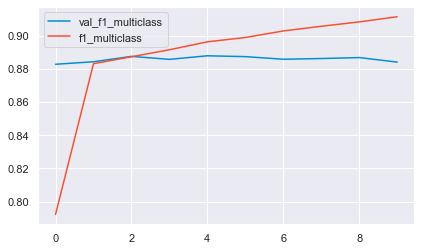

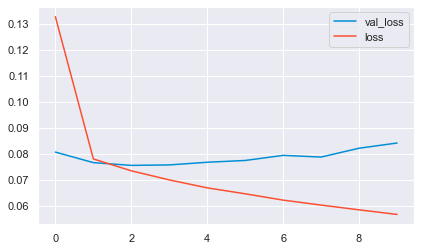

In [386]:
sns.set_style("darkgrid")
sns.set_context('notebook')

df = pd.DataFrame(history.history)
df[['val_f1_multiclass', 'f1_multiclass']].plot.line();
df[['val_loss', 'loss']].plot.line();

In [20]:
loss, accuracy = model.evaluate([dev_sentences, dev_prefix, dev_suffix], dev_tags_1hot,
                       batch_size=batch_size, verbose=1)
print('Test loss:', loss)
print('Test F1 score:', accuracy)

139/139 [==============================] - 5s 35ms/step - loss: 0.0822 - f1_multiclass: 0.8855
Test loss: 0.08220064640045166
Test F1 score: 0.8855397701263428


In [21]:
batch_size = 256
epochs = 10

loss_w = weighted_categorical_crossentropy(train_tags)

# compile the model we have defined above
model.compile(loss=loss_w, 
              optimizer='adam',
              metrics=[f1_multiclass], #, f1, 
              run_eagerly=True)

# run training and capture ouput log
history = model.fit([train_sentences, train_prefix, train_suffix], train_tags_1hot,
                    batch_size=batch_size,
                    validation_data=validation_data,
                    epochs=epochs,
                    verbose=1)

2022-02-09 19:14:46.145851: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 37415840 exceeds 10% of free system memory.
2022-02-09 19:14:46.216301: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 37415840 exceeds 10% of free system memory.


Epoch 1/10
416/416 [==============================] - 72s 173ms/step - loss: 0.2140 - f1_multiclass: 0.9111 - val_loss: 0.3346 - val_f1_multiclass: 0.8763
Epoch 2/10
416/416 [==============================] - 92s 221ms/step - loss: 0.2069 - f1_multiclass: 0.9134 - val_loss: 0.3444 - val_f1_multiclass: 0.8806
Epoch 3/10
416/416 [==============================] - 105s 253ms/step - loss: 0.2007 - f1_multiclass: 0.9154 - val_loss: 0.3604 - val_f1_multiclass: 0.8781
Epoch 4/10
416/416 [==============================] - 108s 259ms/step - loss: 0.1959 - f1_multiclass: 0.9173 - val_loss: 0.3683 - val_f1_multiclass: 0.8764
Epoch 5/10
416/416 [==============================] - 106s 255ms/step - loss: 0.1901 - f1_multiclass: 0.9195 - val_loss: 0.3887 - val_f1_multiclass: 0.8771
Epoch 6/10
416/416 [==============================] - 98s 235ms/step - loss: 0.1858 - f1_multiclass: 0.9210 - val_loss: 0.3985 - val_f1_multiclass: 0.8775
Epoch 7/10
276/416 [==================>...........] - ETA: 31s - lo

KeyboardInterrupt: 

In [405]:
loss, accuracy = model.evaluate([dev_sentences, dev_prefix, dev_suffix], dev_tags_1hot,
                       batch_size=batch_size, verbose=1)
print('Test loss:', loss)
print('Test F1_score:', accuracy)

139/139 [==============================] - 41s 295ms/step - loss: 0.6384 - f1_multiclass: 0.87230s - loss: 0.6384 - f1_multiclass: 0.872
Test loss: 0.6384361386299133
Test accuracy: 0.8723019957542419


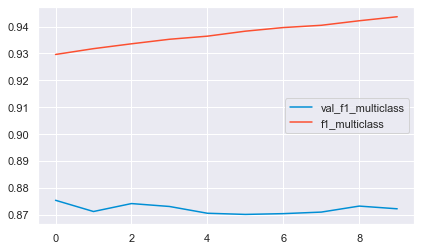

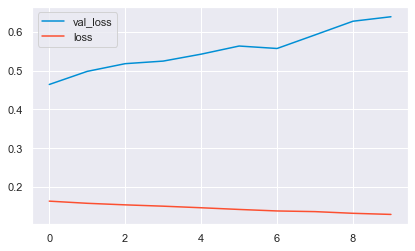

In [406]:
df = pd.DataFrame(history.history)
df[['val_f1_multiclass', 'f1_multiclass']].plot.line();
df[['val_loss', 'loss']].plot.line();

It looks like our weighted cross entropy does not provide better results and creates an overfitting issue, therefore we will continue forward with normal cross entropy

Let's see if we can improve our model by tuning the hyperparameters. We define the function create model that we will then use to perform an exhaustive search over the following parameters:

* Batch size: 4, 128, 512
* Epochs: 4, 7, 10 (From previous two models we saw the network tends to overfit beyond 10)
* LSTM units: 128, 256
* Optimization algorithm: SGD, RMSprop, Adadelta, Adam
* dropout: 0.2, 0.4 (We try differnt dropout rates to combat overfitting)

In [142]:
# First lets prepare some development data that will be smaller
df = pd.read_csv('NER_data.csv')
df_dev = df[:7500]

words_dev = [[word  for word, tag in literal_eval(tup)] for tup in df_dev.tagged_input]
tags_dev = [[tag  for word, tag in literal_eval(tup)] for tup in df_dev.tagged_input]

NYT_dev_data = list(zip(words_dev, tags_dev))

# Now we split the data into train, dev, test - 60/20/20
train_NER_dev, test_NER_dev = train_test_split(NYT_dev_data, test_size=0.2, random_state=1, shuffle=True)

train_instances_d = [(words, tags) for (words, tags) in train_NER_dev]
test_instances_d = [(words, tags) for (words, tags) in test_NER_dev]

# apply integer mapping
train_instances_int_d = convert2ints(train_instances_d)
test_instances_int_d = convert2ints(test_instances_d)

# separate the words from the tags
train_sentences_d, train_tags_d = zip(*train_instances_int_d) 
test_sentences_d, test_tags_d = zip(*test_instances_int_d) 

print(train_instances_d[0][0])
print(train_sentences_d[0])
print(train_instances_d[0][1])
print(train_tags_d[0])

MAX_LENGTH = 22

train_prefix_d, train_suffix_d = zip(*convert2ints_pre_suf(train_instances_d))
test_prefix_d, test_suffix_d = zip(*convert2ints_pre_suf(test_instances_d))

# Padding
train_prefix_d = pad_sequences(train_prefix_d, maxlen=MAX_LENGTH, padding='post')
train_suffix_d = pad_sequences(train_suffix_d, maxlen=MAX_LENGTH, padding='post')

test_prefix_d = pad_sequences(test_prefix_d, maxlen=MAX_LENGTH, padding='post')
test_suffix_d = pad_sequences(test_suffix_d, maxlen=MAX_LENGTH, padding='post')

train_sentences_d = pad_sequences(train_sentences_d, maxlen=MAX_LENGTH, padding='post')
test_sentences_d = pad_sequences(test_sentences_d, maxlen=MAX_LENGTH, padding='post')

train_tags_d = pad_sequences(train_tags_d, maxlen=MAX_LENGTH, padding='post')
test_tags_d = pad_sequences(test_tags_d, maxlen=MAX_LENGTH, padding='post')

train_tags_1hot_d = to_categorical(train_tags_d, len(tag2int_d))
test_tags_1hot_d = to_categorical(test_tags_d, len(tag2int_d))


print(train_tags_d[0], end=' / ')
print(train_tags_1hot_d[0].shape)
print(train_tags_1hot_d[0])

['1', 'teaspoon', 'minced', 'fresh', 'ginger']
[51, 7669, 5232, 4209, 4327]
['O', 'O', 'O', 'O', 'B - INGREDIENT']
[3, 3, 3, 3, 1]
[3 3 3 3 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] / (22, 4)
[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


In [17]:
def create_model(units_lstm, optimizer='adam', run_eagerly=False, metrics=None, dropout = 0.3, loss = 'categorical_crossentropy'):
    inputs_w = Input((MAX_LENGTH, ), 
               name='word_IDs')
    embeddings = Embedding(input_dim=len(word2int), 
                           output_dim=300,
                           mask_zero=False,
                           name='embeddings')(inputs_w)

    inputs_pre = Input((MAX_LENGTH, ), 
                   name='prefix_IDs')
    embeddings_pre = Embedding(input_dim=len(prefix2int),
                           output_dim=22,
                           mask_zero=False,
                           name='embeddings_prefix')(inputs_pre)

    inputs_suf = Input((MAX_LENGTH, ), 
                   name='suffix_IDs')
    embeddings_suf = Embedding(input_dim=len(suffix2int),
                           output_dim=22,
                           mask_zero=False,
                           name='embeddings_suffix')(inputs_suf)

    concat = Concatenate(name="concatenate")([embeddings, embeddings_pre, embeddings_suf])

    bilstm = Bidirectional(LSTM(units=units_lstm, 
                                return_sequences=True), 
                           name="Bi-LSTM")(concat)
    dropout = Dropout(dropout, name='dropout')(bilstm)
    bilstm_out = Dense(len(tag2int), name='inter_output')(dropout)
    output = Activation('softmax', name='softmax')(bilstm_out)

    created_model = Model(inputs=[inputs_w, inputs_pre, inputs_suf], outputs=[output], name="DVD")
    print(created_model.summary())

    # compile the model we have defined above
    created_model.compile(loss=loss,
                  optimizer=optimizer, 
                  run_eagerly=run_eagerly,
                  metrics=metrics)
    
    return created_model

In [ ]:
# define the grid search parameters
batch_size = [4, 128, 512]
epochs = [4, 7, 10]
units_lstm = [128, 256]
dropout = [0.2, 0.4]
loss = ['categorical_crossentropy']
optimizer = ['SGD', 'RMSprop', 'Adadelta', 'Adam'] # from Reimers & Gurevych (2017), Optimal Hyperparameters for Deep LSTM-Networks for Sequence Labeling Tasks 

param_grid = dict(batch_size=batch_size, epochs=epochs, units_lstm=units_lstm, optimizer=optimizer, loss=loss, dropout=dropout)

best_params, f1_max = None, 0 
results = []

for params in list(itertools.product(*param_grid.values())):
    print(f"Fitting with parameters: Batch size={params[0]} - Epoch={params[1]} - Dimension of LSTM={params[2]} - Optimizer={params[3]} - loss={params[4]} - dropout={params[5]}",
           file=sys.stderr, flush=True)
    model_grid = create_model(optimizer=params[3], units_lstm=params[2], dropout=params[5], loss=params[4])
    model_grid.fit([train_sentences_d, train_prefix_d, train_suffix_d], train_tags_1hot_d,
                    batch_size=params[0],
                    epochs=params[1],
                    verbose=0)
    pred = model_grid.predict([test_sentences_d, test_prefix_d, test_suffix_d])
    f1_grid = f1_score(test_tags_d.ravel(), pred.argmax(axis=2).ravel(), average="macro", zero_division=0)
    print(f"Finished training with F1-score={f1_grid}", file=sys.stderr, flush=True)
    results.append((params, f1_grid))
    if f1_grid > f1_max:
        f1_max = f1_grid
        best_params = params
print(best_params)

In [21]:
# After a 14 hour run time the best params are:
# Batch size, Epochs, LTSM units, optimizer, loss, dropout 
# (32, 7, 128, 'RMSprop', 'categorical_crossentropy', 0.4)
best_params = (32, 7, 128, 'adam', 'categorical_crossentropy', 0.4)

# Define best model
best_model = create_model(optimizer=best_params[3], 
                          units_lstm=best_params[2], 
                          dropout=best_params[5], 
                          loss=best_params[4],
                          run_eagerly=True,
                          metrics=[f1_multiclass]);

best_model.fit([train_sentences, train_prefix, train_suffix], train_tags_1hot,
                validation_data=validation_data,
                batch_size=best_params[0],
                epochs=best_params[1],
                verbose=1);

Model: "DVD"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
word_IDs (InputLayer)           [(None, 22)]         0                                            
__________________________________________________________________________________________________
prefix_IDs (InputLayer)         [(None, 22)]         0                                            
__________________________________________________________________________________________________
suffix_IDs (InputLayer)         [(None, 22)]         0                                            
__________________________________________________________________________________________________
embeddings (Embedding)          (None, 22, 300)      2494500     word_IDs[0][0]                   
________________________________________________________________________________________________

In [22]:
loss, accuracy = best_model.evaluate([test_sentences, test_prefix, test_suffix], test_tags_1hot,
                       batch_size=4, verbose=1)
print('Test loss:', loss)
print('Test F1_score:', accuracy)

8858/8858 [==============================] - 202s 23ms/step - loss: 0.0842 - f1_multiclass: 0.8772
Test loss: 0.08420191705226898
Test F1_score: 0.8771582841873169


In [23]:
# Model is giving substantioally better results from the perceptron and manages to succeessfully predict accross classes!
pred = best_model.predict([test_sentences, test_prefix, test_suffix])
print(classification_report(test_tags.ravel(), pred.argmax(axis=2).ravel()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    550353
           1       0.86      0.84      0.85     37166
           2       0.80      0.65      0.72     30923
           3       0.93      0.97      0.95    161062

    accuracy                           0.97    779504
   macro avg       0.90      0.87      0.88    779504
weighted avg       0.97      0.97      0.97    779504



In [24]:
# Saving model and corpus2int
best_model.save('models/bilstm_best')
pickle.dump((word2int, prefix2int, suffix2int, int2tag), open("models/corpus.pickle", "wb"))

2022-02-09 20:28:53.764461: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/bilstm_best/assets


INFO:tensorflow:Assets written to: models/bilstm_best/assets


In [25]:
def plot_multiclass_conf_matrix(y_true, y_pred, labels, title='Confusion Matrix'):
    
    c_mat = confusion_matrix(y_true, y_pred, labels=labels, normalize="true")

    plt.figure(figsize=(12,12))
    plt.title(title+"\n", size=24)
    sns.heatmap(c_mat, fmt='.2f', annot=True, square=True, annot_kws={'size':10}, xticklabels=labels,
                yticklabels=labels)
    plt.ylabel("True Value", size=18)
    plt.xlabel("Predicted Value", size=18)
    plt.show()

In [26]:
y_true_sp = [tag for (words, tags) in test_instances for tag in tags]
y_pred_sp = []
for i in range(len(test_instances)):
    y_pred_sp += sp2.predict(test_instances[i][0], method='greedy')
labels = sorted(list(tagset))

plot_multiclass_conf_matrix(y_true_sp, y_pred_sp, labels, title='Simple Structured Perceptron Confusion Matrix')

NameError: name 'sp2' is not defined

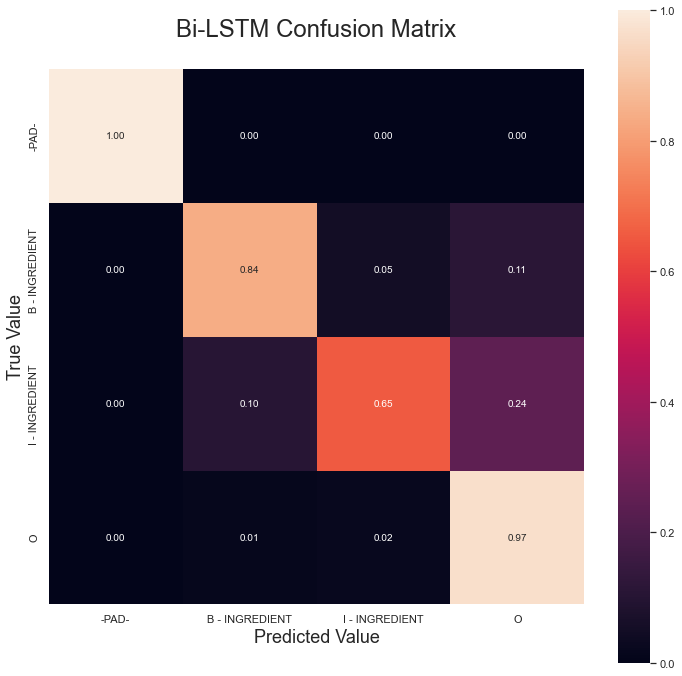

In [27]:
y_true_bilstm = test_tags.ravel().tolist()
y_true_bilstm = [int2tag[i] for i in y_true_bilstm]
y_pred_bilstm = pred.argmax(axis=2).ravel().tolist()
y_pred_bilstm = [int2tag[i] for i in y_pred_bilstm]

labels = sorted(list(set(y_true_bilstm)))

c_mat = plot_multiclass_conf_matrix(y_true_bilstm, y_pred_bilstm, labels=labels, title='Bi-LSTM Confusion Matrix')

#### Final analysis on scrapped recipie data!

In [32]:
# Now lets apply our classifiers to the raw recepie data
# Lets explore the most popular recepies

# We define most popular with: rating larger than 4 and not exactly 5
# This is due to the data annomaly we saw earlier characterized by spikes in distribution 
# around the whole numbers - I suspect is driven by low number of reviews
df_ins = df_allR
df_ins = df_allR[(df_allR.rating > 4) & (df_allR.rating != 5)]
len(df_ins)

31219

In [ ]:
try:
    df_ins = pd.read_csv('recepies_ext_ing.csv')
except:
    print('Dataset missing run the following cell!')

In [33]:

def extract_ingredient(recipe):

    recipe = str(recipe).split()
    # convert to integers
    recipe_int = [[word2int.get(word, 1) for word in recipe]]
    # replace prefixes
    prefix_ints = [[prefix2int.get(word[:3], 1) for word in recipe]]
    # replace suffixes
    suffix_ints = [[suffix2int.get(word[-3:], 1) for word in recipe]]
    
    # add padding
    recipe_int = pad_sequences(recipe_int, maxlen=MAX_LENGTH, padding='post')
    prefix_int = pad_sequences(prefix_ints, maxlen=MAX_LENGTH, padding='post')
    suffix_int = pad_sequences(suffix_ints, maxlen=MAX_LENGTH, padding='post')

    predictions = best_model.predict([recipe_int, prefix_int, suffix_int])

    for prediction in predictions:
        token_sequence = [int2tag[np.argmax(prediction[i])] for i in range(len(recipe))]
    
    output = []
    for item, tag in zip(recipe, token_sequence):
        if tag not in set({'-PAD-','O'}):
            output.append(item)
    
    return ' '.join(output).strip()

df_ins['ext_ingredients'] = df_ins.ingredients.progress_apply(extract_ingredient)

 55%|█████▌    | 17194/31219 [34:41<28:18,  8.26it/s]  


KeyboardInterrupt: 

In [356]:
# Looks like our ingredient extraction worked very well!
df_ins.head()

Unnamed: 0                                                url  \
0           0  https://www.allrecipes.com/recipe/241038/micro...   
1           0  https://www.allrecipes.com/recipe/241038/micro...   
2           0  https://www.allrecipes.com/recipe/241038/micro...   
3           0  https://www.allrecipes.com/recipe/241038/micro...   
4           0  https://www.allrecipes.com/recipe/241038/micro...   

                           name    rating  \
0  Microwave Chocolate Mug Cake  4.476778   
1  Microwave Chocolate Mug Cake  4.476778   
2  Microwave Chocolate Mug Cake  4.476778   
3  Microwave Chocolate Mug Cake  4.476778   
4  Microwave Chocolate Mug Cake  4.476778   

                              ingredients  \
0               1⁄4 cup all-purpose flour   
1                       ¼ cup white sugar   
2  2 tablespoons unsweetened cocoa powder   
3                  ⅛ teaspoon baking soda   
4                         ⅛ teaspoon salt   

                                          directions  \
0  1. Mix flour, sugar, cocoa powder, baking soda...   
1  1. Mix flour, sugar, cocoa powder, baking soda...   
2  1. Mix flour, sugar, cocoa powder, baking soda...   
3  1. Mix flour, sugar, cocoa powder, baking soda...   
4  1. Mix flour, sugar, cocoa powder, baking soda...   

                                input_tokenized    ext_ingredients  
0            [1⁄4, cup, all, -, purpose, flour]  all-purpose flour  
1                        [¼, cup, white, sugar]        white sugar  
2  [2, tablespoons, unsweetened, cocoa, powder]       cocoa powder  
3                   [⅛, teaspoon, baking, soda]        baking soda  
4                           [⅛, teaspoon, salt]               salt

In [357]:
df_ins.to_csv('data/recepies_ext_ing.csv')

In [ ]:
df_ins = df_ins[df_ins.ext_ingredients != '']
len(df_ins)

In [360]:
df1 = df_ins.groupby(['url'])['ext_ingredients'].apply(list).reset_index()
df_ins = pd.merge(df1, df_ins[['url','rating','directions','name']], left_on='url', right_on='url')
df_ins = df_ins.loc[df_ins.astype(str).drop_duplicates().index].reset_index().drop(columns=['index'])

In [361]:
# Use the same preprocessing as used on the dataset used to train the classifier
def preprocess_df(df):
    
    def process_string(recipe):
        prep_r = []
        for ing in recipe:
            ing = [WordNetLemmatizer().lemmatize(word) for word in str(ing).split()]
            ing = ' '.join(ing)
            ing = re.sub(r'\(.*oz.\)|crushed|crumbles|ground|minced|powder|chopped|sliced','', ing)
            ing = re.sub("[^a-zA-Z]", " ", ing)
            ing = ing.lower().strip()
            prep_r.append(ing)
            
        return prep_r
    
    df['ext_ingredients'] = df['ext_ingredients'].apply(process_string)
    
    return df

df_ins = preprocess_df(df_ins)
df_ins.head()

url  \
0  https://www.allrecipes.com/recipe/100373/choco...   
1  https://www.allrecipes.com/recipe/100496/honey...   
2  https://www.allrecipes.com/recipe/100827/baked...   
3  https://www.allrecipes.com/recipe/10101/chocol...   
4  https://www.allrecipes.com/recipe/103805/scott...   

                                     ext_ingredients    rating  \
0  [poppy seed, buttermilk, egg, butter, white su...  4.600000   
1  [butter, nan, white sugar, honey, egg, butterm...  4.476190   
2  [graham cracker crumb, cocoa, sugar, butter, s...  4.533333   
3  [butter, white sugar, vegetable oil, egg, vani...  4.625000   
4  [water, white sugar, mixed spice, cinnamon, dr...  4.333333   

                                          directions  \
0  1. Preheat oven to 350 degrees F (175 degrees ...   
1  1. Preheat oven to 350 degrees F (175 degrees ...   
2  1. Preheat oven to 350 degrees F (175 degrees ...   
3  1. Preheat oven to 325 degrees F (170 degrees ...   
4  1. In a saucepan, combine the water, sugar, mi...   

                                 name  
0           Chocolate Poppy Seed Cake  
1    Honey Cupcakes with Strawberries  
2  Baked Chocolate Caramel Cheesecake  
3             Chocolate Zucchini Bars  
4                    Scottish Pudding

In [362]:
df_ins.shape

(2540, 5)

In [363]:
instances = df_ins.ext_ingredients.apply(lambda x: ' '.join(x)).tolist()
X_p = tfidf_vectorizer.transform(instances)

In [365]:
predictions_allR = best_clf.predict(X_p)

In [366]:
predictions_allR

array(['southern_us', 'southern_us', 'southern_us', ..., 'southern_us',
       'southern_us', 'moroccan'], dtype=object)

In [367]:
df_ins['cuisine'] = predictions_allR
df_ins.to_csv('final_recepies.csv')

In [368]:
df_ins.head(10)

url  \
0  https://www.allrecipes.com/recipe/100373/choco...   
1  https://www.allrecipes.com/recipe/100496/honey...   
2  https://www.allrecipes.com/recipe/100827/baked...   
3  https://www.allrecipes.com/recipe/10101/chocol...   
4  https://www.allrecipes.com/recipe/103805/scott...   
5  https://www.allrecipes.com/recipe/104772/rum-p...   
6  https://www.allrecipes.com/recipe/105768/moist...   
7  https://www.allrecipes.com/recipe/106335/cherr...   
8  https://www.allrecipes.com/recipe/106341/straw...   
9  https://www.allrecipes.com/recipe/107029/aunti...   

                                     ext_ingredients    rating  \
0  [poppy seed, buttermilk, egg, butter, white su...  4.600000   
1  [butter, nan, white sugar, honey, egg, butterm...  4.476190   
2  [graham cracker crumb, cocoa, sugar, butter, s...  4.533333   
3  [butter, white sugar, vegetable oil, egg, vani...  4.625000   
4  [water, white sugar, mixed spice, cinnamon, dr...  4.333333   
5  [butter, nan, vegetable oil, white sugar, egg,...  4.515152   
6  [butter, white sugar, egg, buttermilk, red foo...  4.178414   
7  [cherry chip cake mix, cherry pie filling, alm...  4.580645   
8  [rhubarb, nan, strawberry, nan, white sugar, n...  4.677419   
9  [white sugar, all purpose flour, baking, milk,...  4.615385   

                                          directions  \
0  1. Preheat oven to 350 degrees F (175 degrees ...   
1  1. Preheat oven to 350 degrees F (175 degrees ...   
2  1. Preheat oven to 350 degrees F (175 degrees ...   
3  1. Preheat oven to 325 degrees F (170 degrees ...   
4  1. In a saucepan, combine the water, sugar, mi...   
5  1. Preheat oven to 350 degrees F (175 degrees ...   
6  1. Preheat oven to 350 degrees F (175 degrees ...   
7  1. Preheat an oven to 350 degrees F (175 degre...   
8  1. Preheat the oven to 350 degrees F (175 degr...   
9  1. Preheat the oven to 350 degrees F (175 degr...   

                                 name      cuisine  
0           Chocolate Poppy Seed Cake  southern_us  
1    Honey Cupcakes with Strawberries  southern_us  
2  Baked Chocolate Caramel Cheesecake  southern_us  
3             Chocolate Zucchini Bars  southern_us  
4                    Scottish Pudding        irish  
5            Rum-Pineapple Pound Cake  southern_us  
6           Moist Red Velvet Cupcakes  southern_us  
7            Cherry Almond Pound Cake      italian  
8      Strawberry Orange Rhubarb Cake  southern_us  
9      Auntie Emily's Rhubarb Pudding        irish

In [389]:
# Data exploration
raw_ingredients = [ing for ing_list in df_ins.ext_ingredients.tolist() for ing in ing_list if ing != 'nan']
raw_cuisines = df_ins.cuisine.tolist()

# use Counter to get frequencies 
counts_ingr = collections.Counter(raw_ingredients)
counts_cuis = collections.Counter(raw_cuisines)

# Lest begin by exploring the cuisines
# Most common cuisines
counts_cuis.most_common(10)

[('southern_us', 1448),
 ('italian', 327),
 ('french', 223),
 ('british', 193),
 ('mexican', 107),
 ('irish', 79),
 ('russian', 46),
 ('jamaican', 22),
 ('chinese', 21),
 ('greek', 20)]

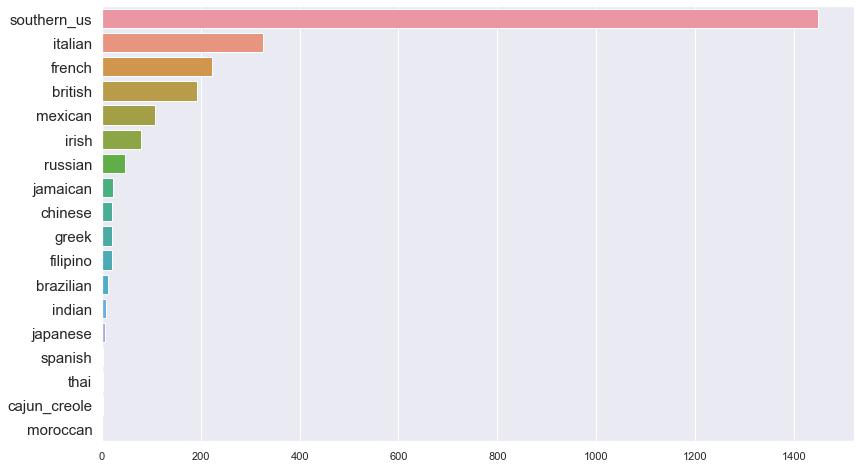

In [390]:
# Lets plot the cuisine distribution
sns.set_style("darkgrid")
sns.set_context("notebook")
sns.set(font_scale = 4)
sns.set(rc={'figure.figsize':(12,8)})

x_c = [c for c, frq in counts_cuis.most_common()]
y_frq = [frq for c, frq in counts_cuis.most_common()]
fbar = sns.barplot(x = y_frq, y = x_c)

fbar.set_yticklabels(fbar.get_ymajorticklabels(), fontsize = 15)
plt.show()

# It seems like the US cuisine is over represented - although this could be an issue with classification I believe it also has to do with the fact that I
# scrapped allrecepies.com -- which is an US website with mainly US users. It could be interesting to explore how would things change if I looked into allrecepies.co.uk for example!
# Another reason might be that from the topic modeling we did on the raw data  it seems like there 
# are lot of baing recipies, which are underrepresented in our training data

# Other than that we can see that we can see that the rest of the cuisines are distribued roughtly as American people, by which I mean that Italian - AMerican, Irish- American etc. are all 
# well represented in the US.

# This lead me to believe that this does not necesserily represent the current cuisine trend in the US, to explore that I will need to find a better source of raw recepies!

('egg', 2243)
('white sugar', 2115)
('butter', 1604)
('vanilla extract', 1581)
('all purpose flour', 1440)
('salt', 1200)
('baking soda', 868)
('baking', 826)
('sugar', 727)
('cinnamon', 715)
('milk', 683)
('water', 642)
('cream cheese', 545)
('vegetable oil', 491)
('brown sugar', 423)


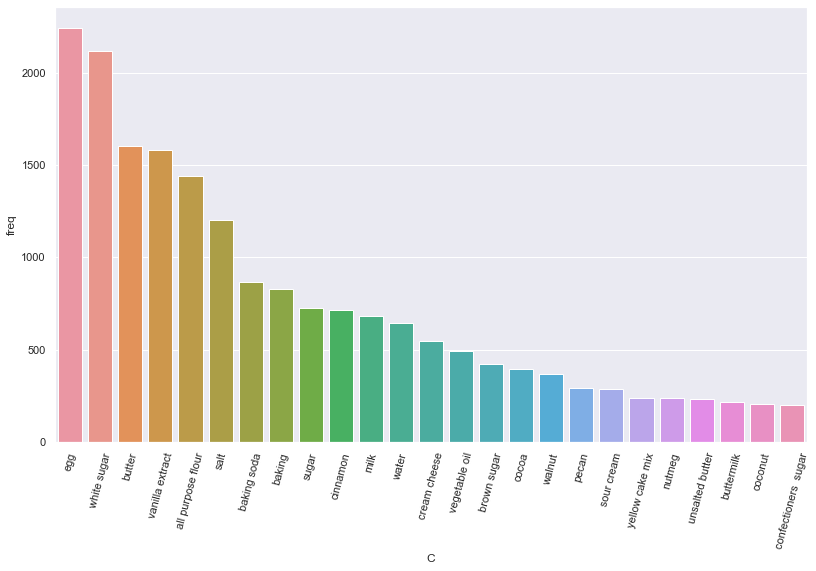

In [391]:
# Finally lets look into the ingredients freq distribution in different recipies
for i in counts_ingr.most_common(15):
    print(i)

fig = sns.barplot(data=pd.DataFrame(counts_ingr.most_common(25),columns=['C','freq']), x='C',y='freq')

# xlabels
for item in fig.get_xticklabels():
    item.set_rotation(75)

## 5. Visualizations (3 pts)

Provide at least 3 visualizations of your work above. These can be in the respective sections. Use labels and legends. Be creative. Just please do not use word clouds...

In [ ]:
# your code here